In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread,imshow
import sqlite3
import math
from os import listdir
from pathlib import Path
import cv2

%run cleaning_visualisation_functions.ipynb

### Need to have the following data in the directorty:
- metadata sheet
- schema image
- pitg db folder

In [2]:
'''metaMaster and schemaMat needed to create homographies for each clip'''

metaMaster = pd.read_csv('metaMaster.csv')

#X,Y coordinates for the 4 corners of the tennis court on the schema.
schemaMat = np.array([[366,641],[1463,641],[366,3018],[1463,3018]])

#loading image of tennis court schema
schema = imread('schema.png')


schemaHalf = cv2.imread('schema.png')
schemaHalf =schemaHalf[1829:3658,0:1829]



In [3]:
#Index of rallies with camera movement that we can't use
camIssues = metaMaster[metaMaster['CamMvmt']== 1]['ID'].values

camIssues

array([  9,  10,  13,  17,  18,  25,  26,  28,  29,  31,  33,  34,  35,
        38,  44,  47,  49,  52,  58,  67,  74,  76,  79,  88,  89,  95,
        98, 101, 102, 103, 104, 109, 114, 115, 116, 117, 118, 119],
      dtype=int64)

### Loads all rallies and concatenate the data into one pandas dataframe

In [7]:
fileloc = '.\pitg'

Path(fileloc).exists()

directory = pd.DataFrame(listdir(fileloc))


fileloc = fileloc +'\\' + directory

fileloc = np.array(fileloc)


In [8]:
'''
Using the function homography(), we obtain the homography matrix for each rally.

The extractBB() function uses the homography matrix and translates each coordinate to the top-down Tennis Schema. 

The translated data from all rallies are concatenated into one large dataframe named allRall.
'''

homog = homography(metaMaster, schemaMat)

allData = []

for i in range(120):
    extractedDF = extractBB(fileloc[i][0], homog[i], i)
    allData.append(extractedDF)

allRall = pd.concat(allData, axis = 0)
allRall = allRall.reset_index()
allRall = allRall.drop('index', axis =1)

In [14]:
allRall.head()

frame_id   class     score           fX           fY  matchID
0        13  player  0.998374  1251.148456  3311.821405        1
1        13  player  0.987601   824.467558   628.614489        1
2        13     ref  0.897093   494.252718    38.406353        1
3       108  player  0.996330   837.823932  1532.434263        1
4       108  player  0.989283   764.395187  2826.899165        1

## Save dataset to allRallies.csv

In [7]:
## Saving extracted DF to folder
#allRall.to_csv('allRallies.csv')

In [4]:
rawRall = pd.read_csv('allRallies.csv', index_col = 'Unnamed: 0')

rawRall

frame_id   class     score           fX           fY  matchID
0             13  player  0.998374  1251.148456  3311.821405        1
1             13  player  0.987601   824.467558   628.614489        1
2             13     ref  0.897093   494.252718    38.406353        1
3            108  player  0.996330   837.823932  1532.434263        1
4            108  player  0.989283   764.395187  2826.899165        1
...          ...     ...       ...          ...          ...      ...
111648       316  player  0.986104   509.716333  2990.711849      120
111649       316  player  0.985379  1671.147368  1931.625544      120
111650       314  player  0.993380   498.089796  2980.877799      120
111651       314  player  0.987769  1669.385346  1931.638338      120
111652       314     ref  0.810184  1093.068781   438.907414      120

[111653 rows x 6 columns]

## Initial Data Analysis and cleaning

The plot of every row in the dataset shows that the machine vision pipeline has picked up many non-player elements. Problematic areas apparent from this plot is as below:

- Players identified past the court space above the 0 line.
- Umpires at the side of the courts
- Umpires at the back of the courts


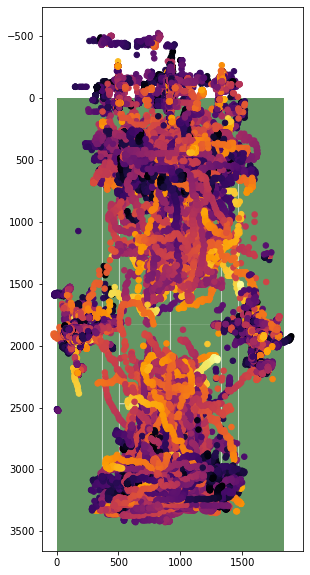

In [9]:
plotAll(rawRall)

### Removes rallies with camera mvmt, and initial removal of stationary umpires

In [6]:
#for each rally, sort by matchID then by frame_id
allRall = rawRall.sort_values(['matchID', 'frame_id'])

# #Remove all classes aside from player
#allRall = allRall[allRall['class']=='player']

#Remove matches with camera movements as 1. 82 rallies left. 
allRall = allRall[~allRall['matchID'].isin(camIssues)]
len(allRall['matchID'].unique())

#Remove rows that are out of bounds from field. Some rows have identified crowds.
allRall = allRall[~(allRall['fY']<125)]

#Remove umpires in the centre right and centre left of the court. 
crit1 = (allRall['fY'] >= 1158)&(allRall['fY']<= 2500)
crit2 = (allRall['fX']<260) | (allRall['fX']>1569)
allRall = allRall[~(crit1 & crit2)]


#Which side of the court they are on using the net as reference point Court 1 far court 0 is close court
allRall['Court'] = allRall.apply(lambda row: 0 if row['fY']>1829 else 1, axis =1)

#Euclidean distance from centre
#centre of far court = 914.5 , 914.5
#centre of close court = 914.5 , 2743.5

allRall['farEuc'] = allRall.apply(lambda row: np.sqrt((row['fX']-914.5)**2 +(row['fY']-914.5)**2),axis =1)
allRall['closeEuc'] = allRall.apply(lambda row: np.sqrt((row['fX']-914.5)**2 +(row['fY']-2743.5)**2),axis =1)

#### Shortest and longest rally

In [11]:
#Stats 

lenRall = []

for i in allRall['matchID'].unique():
    oneRall = allRall[allRall['matchID']==i]
    rallyLength = oneRall['frame_id'].unique().max()
    lenRall.append(rallyLength)
    
lenRall = np.array(lenRall)

print("Shortest Rally in frame numbers: ",lenRall.min())
print("Longest Rally in frame numbers: ",lenRall.max())

Shortest Rally in frame numbers:  34
Longest Rally in frame numbers:  376


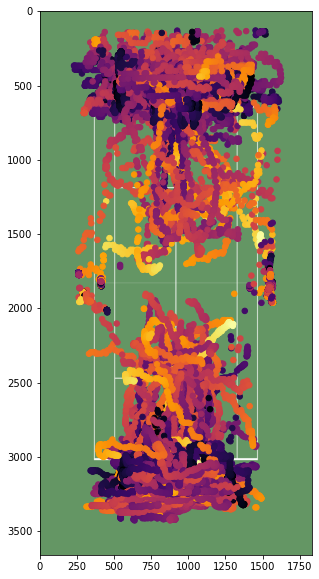

In [12]:
plotAll(allRall)

### Look at every rally separately

<ipython-input-1-952a4e3d0e46>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,10))


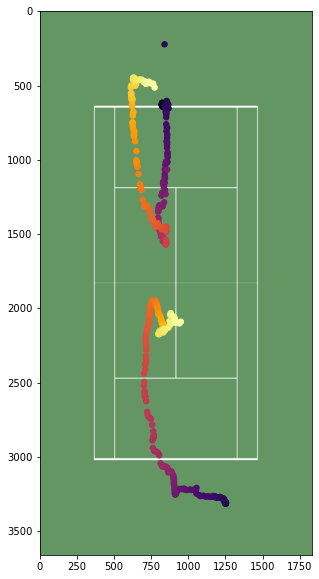

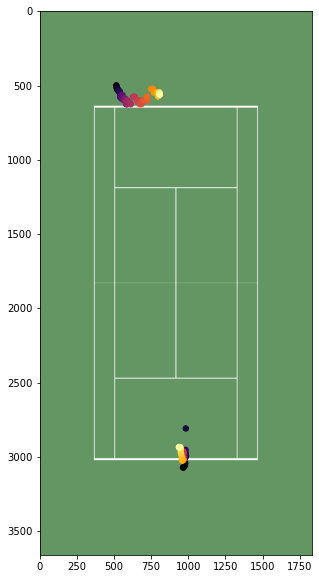

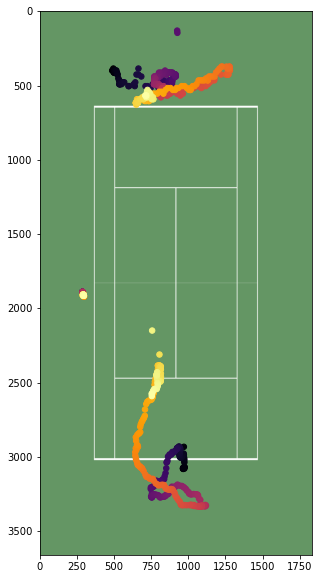

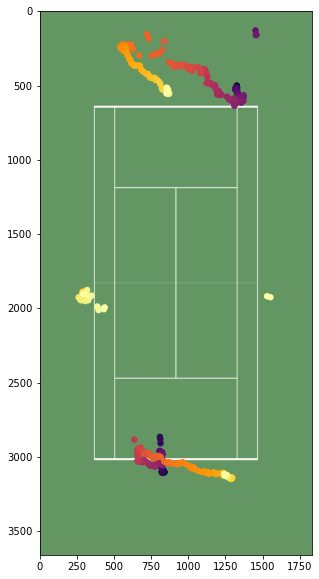

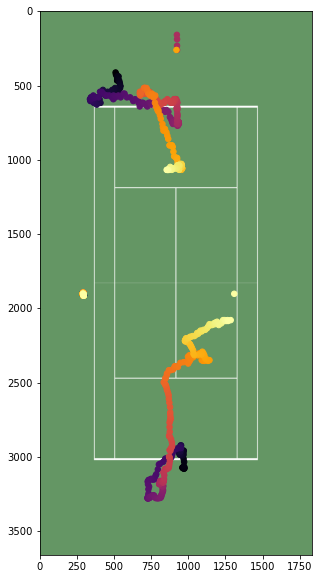

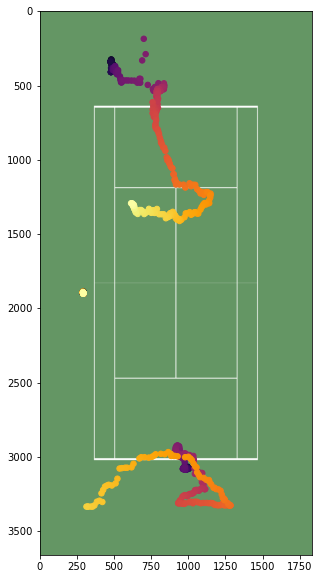

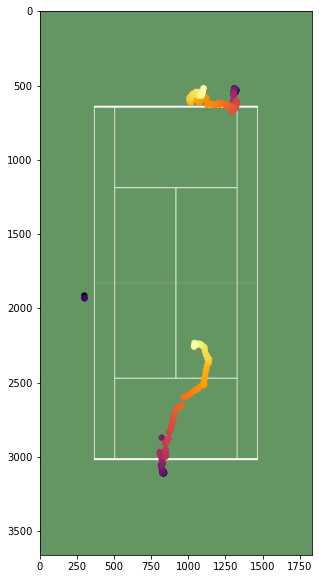

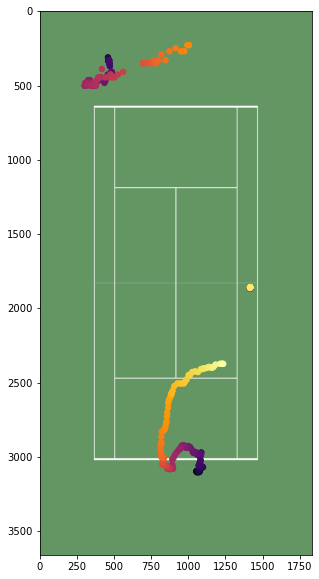

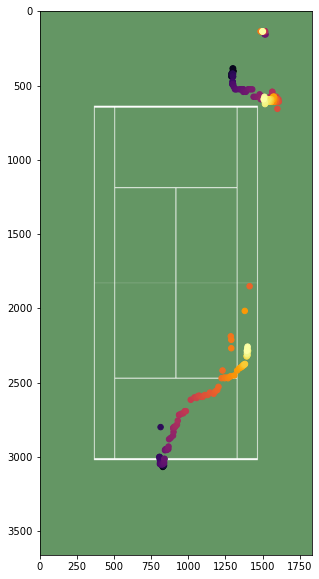

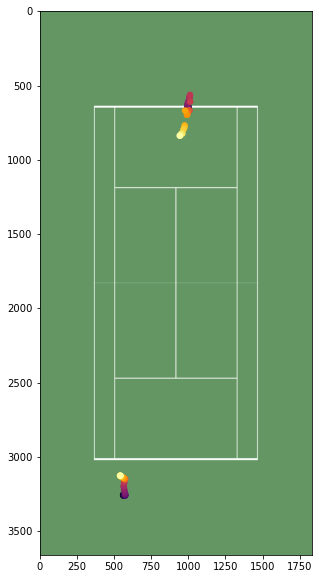

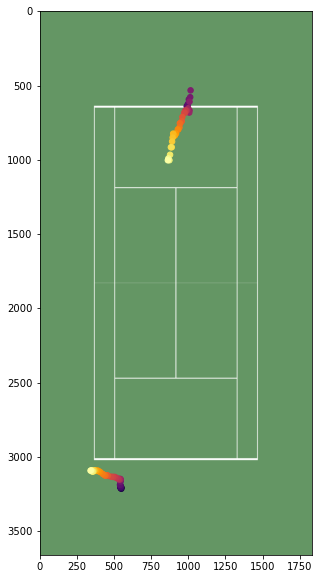

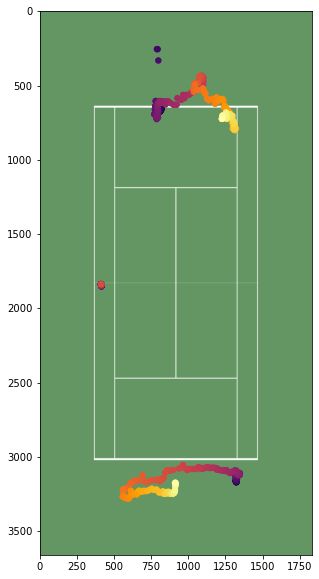

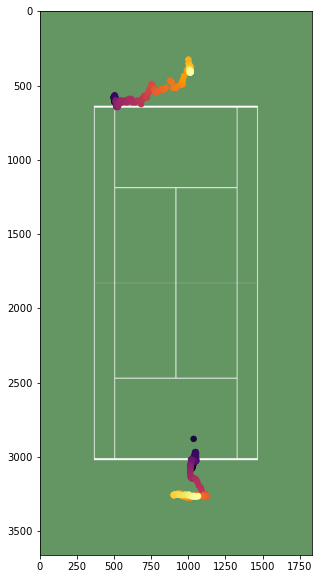

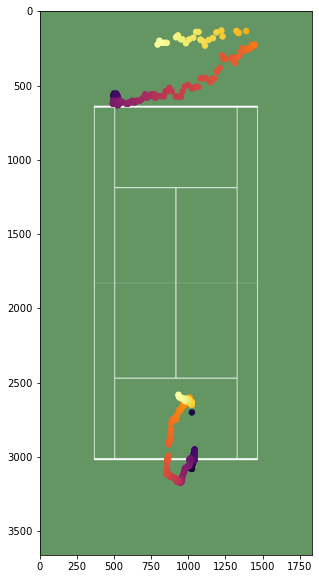

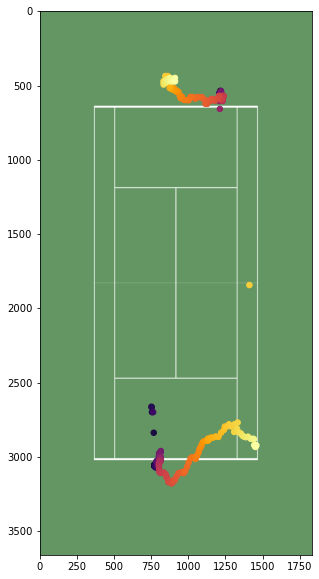

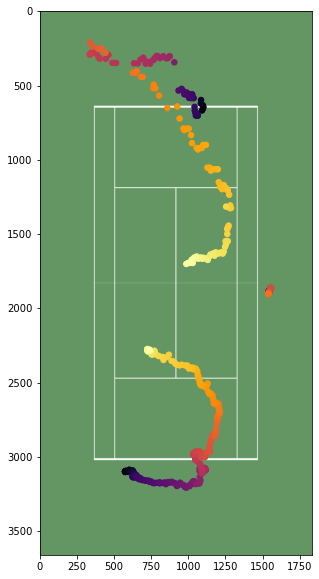

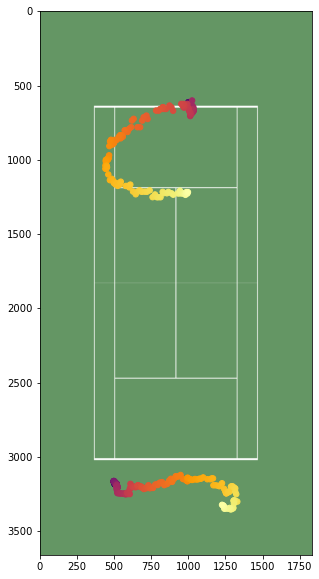

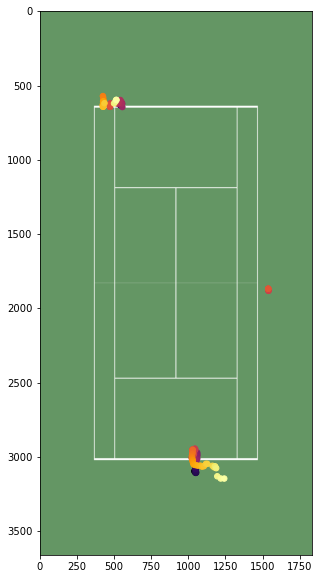

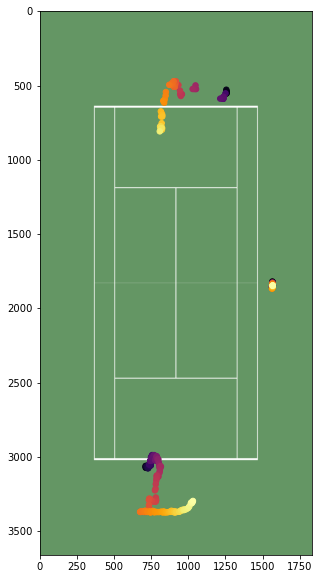

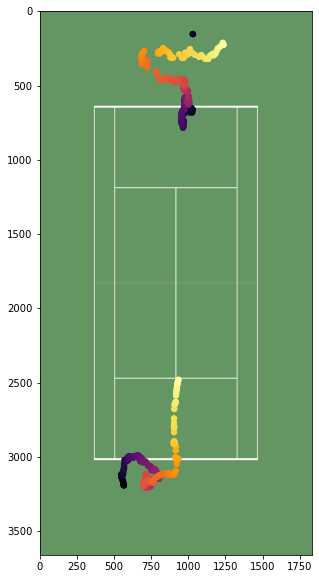

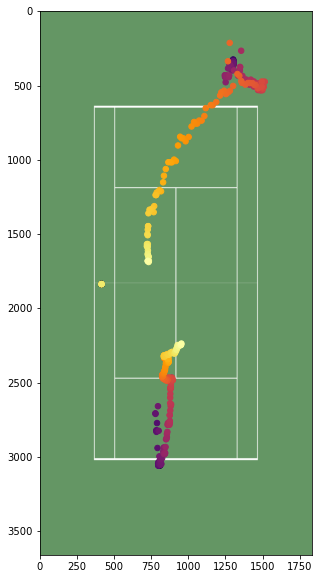

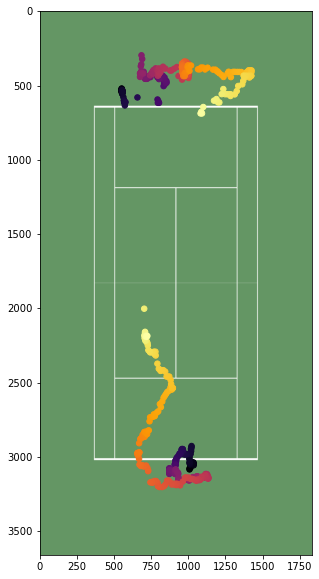

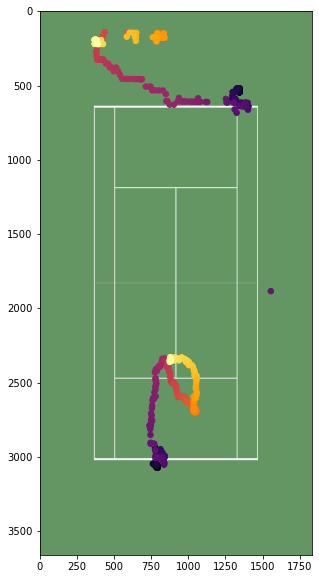

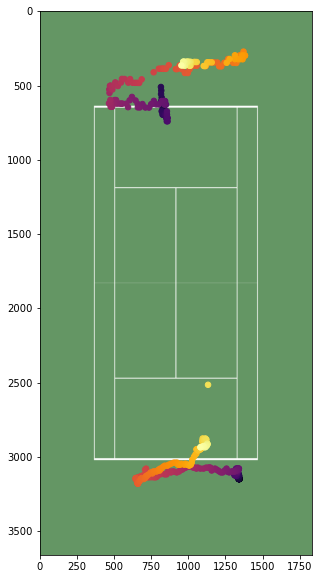

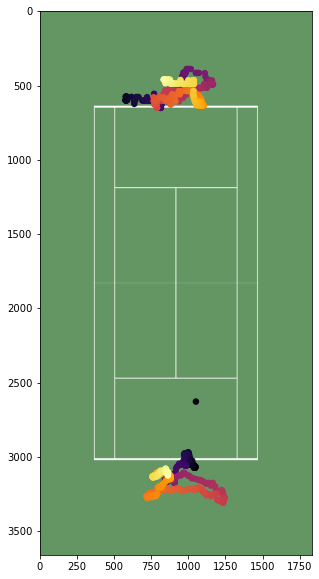

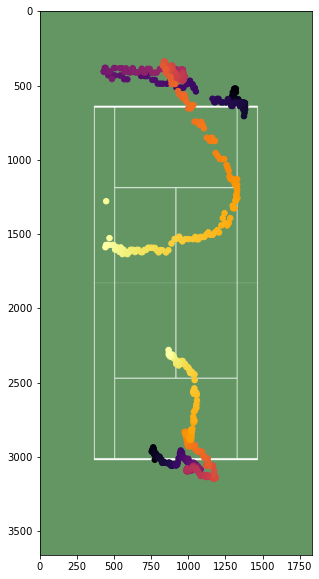

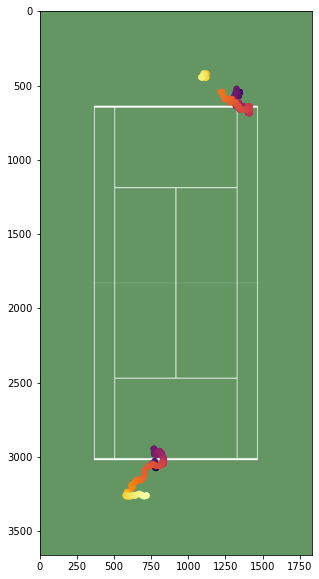

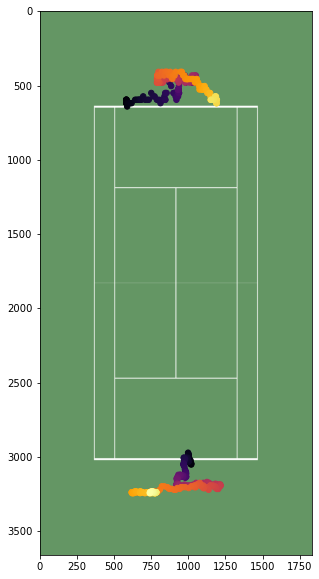

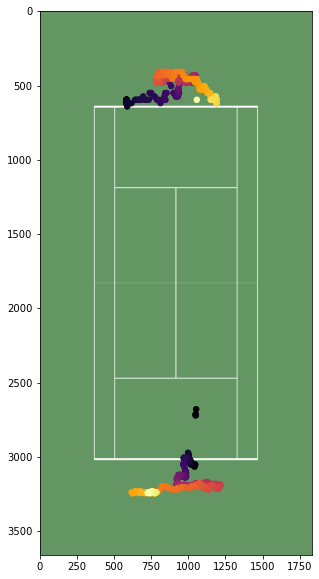

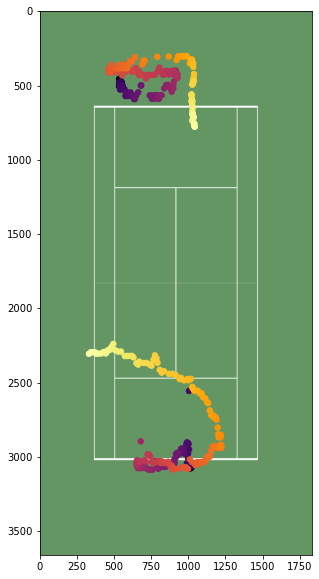

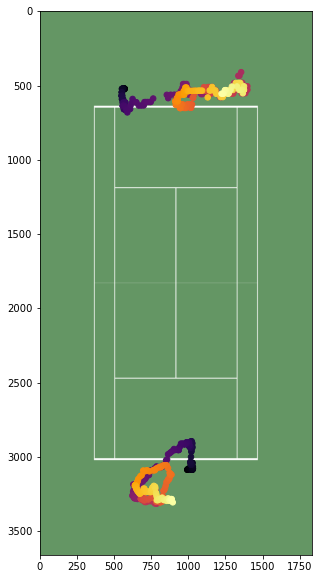

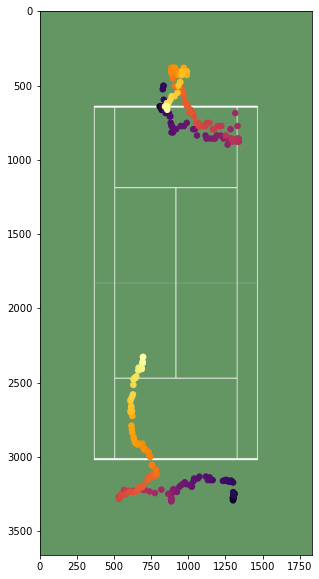

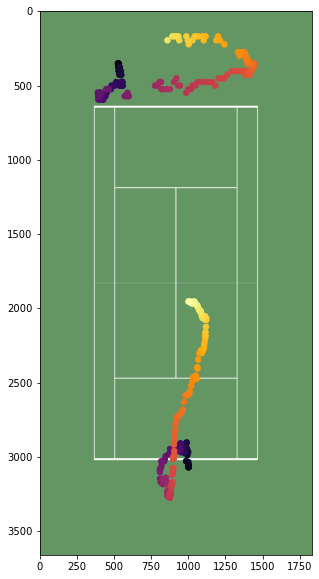

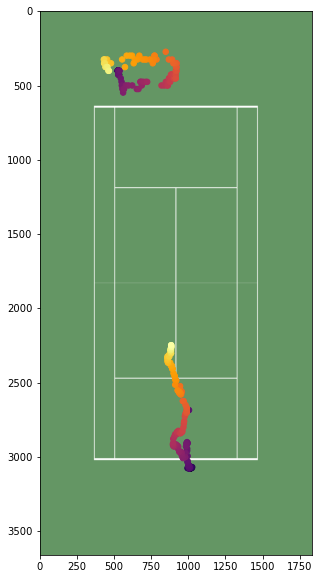

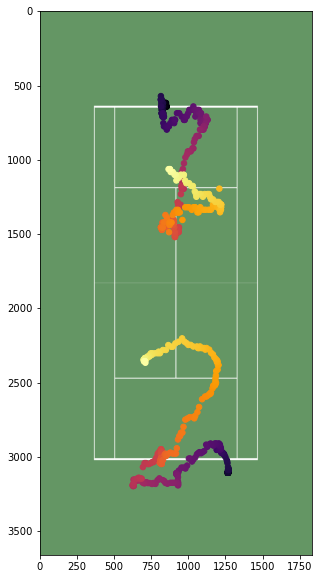

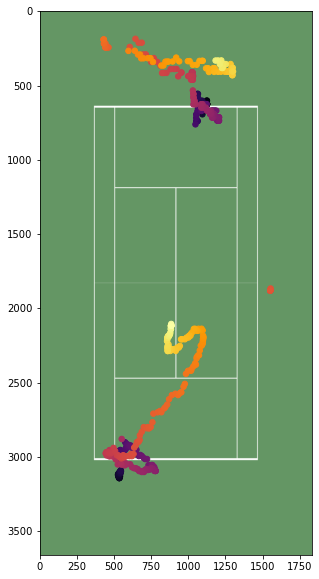

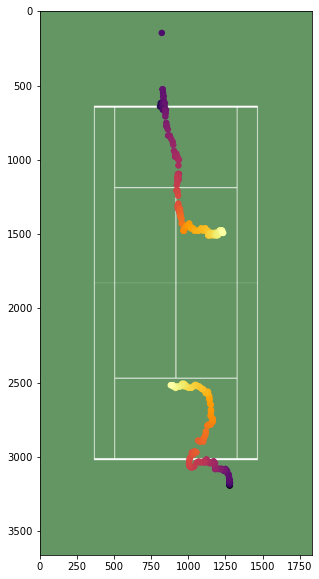

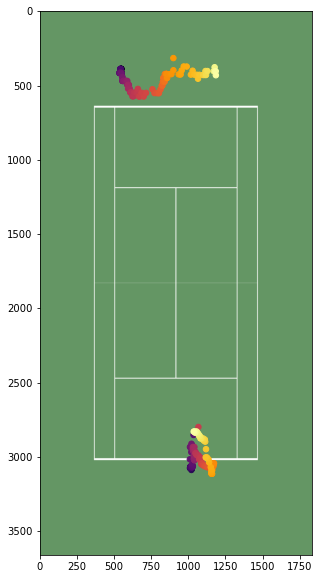

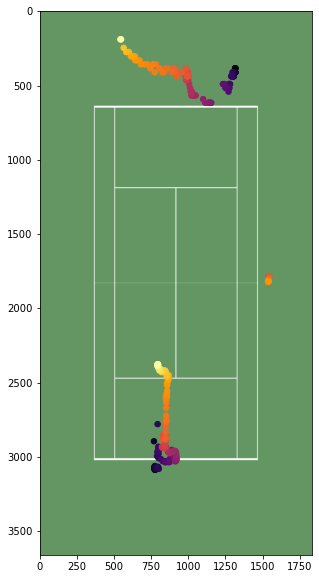

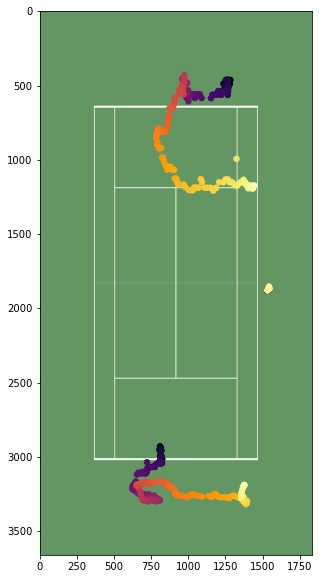

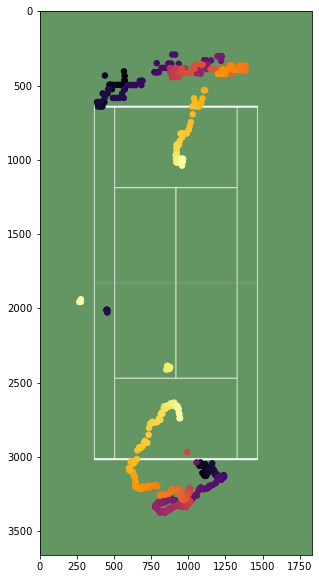

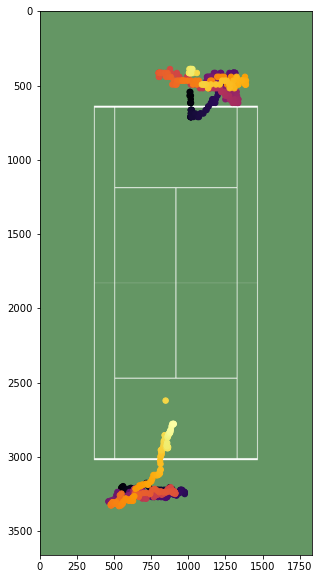

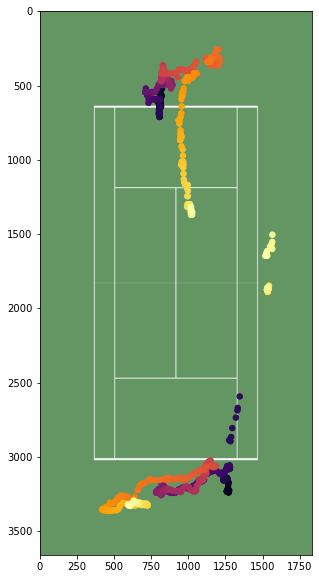

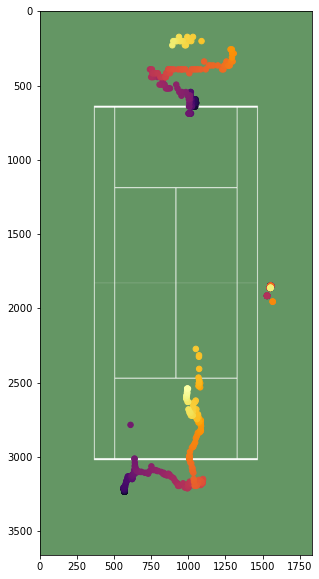

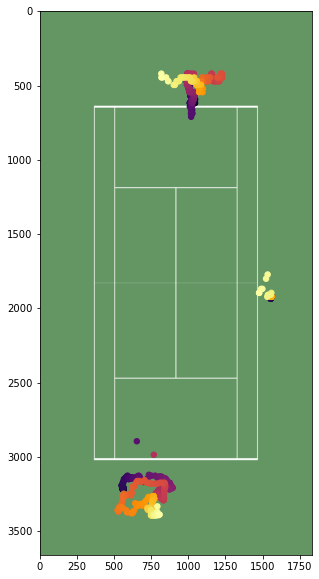

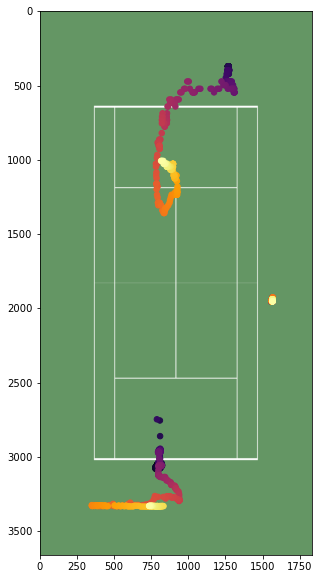

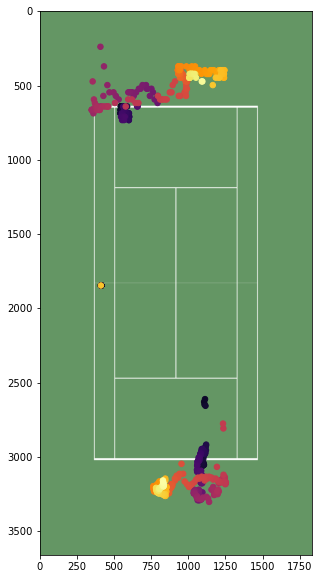

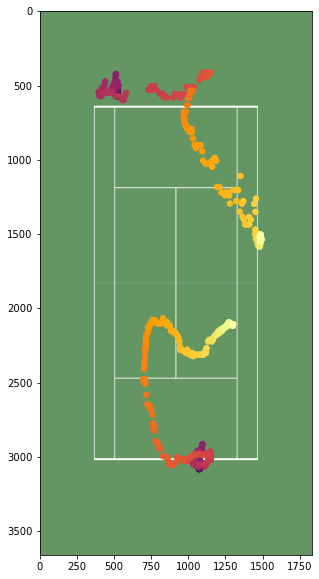

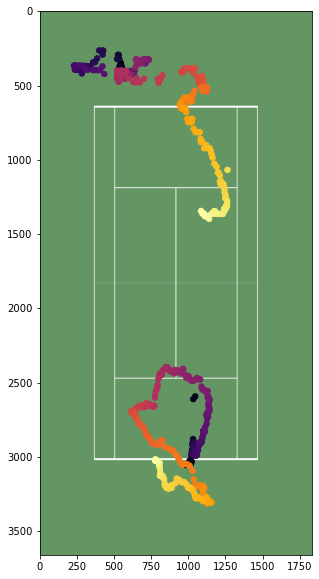

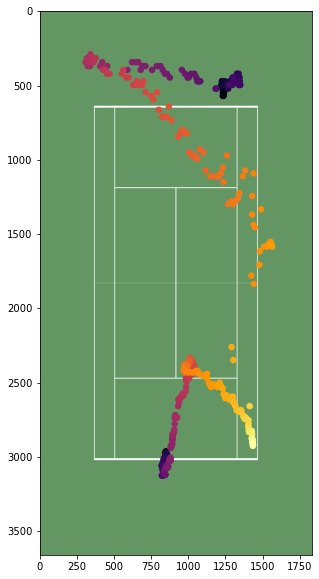

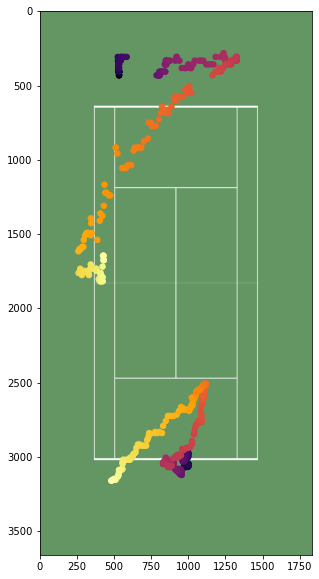

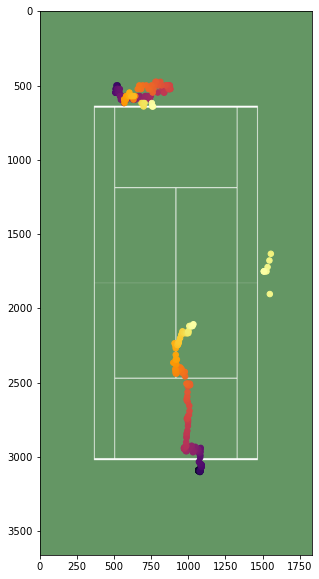

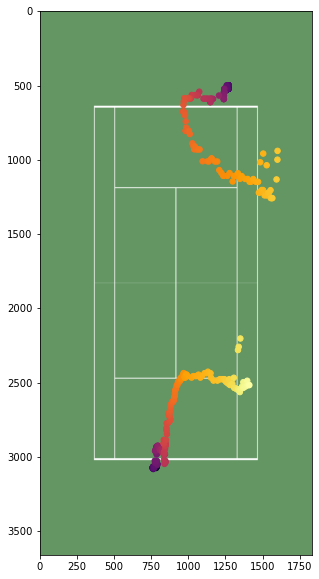

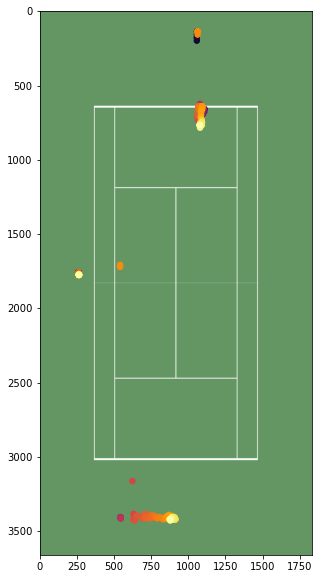

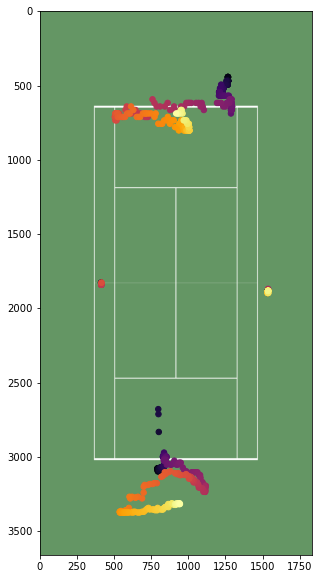

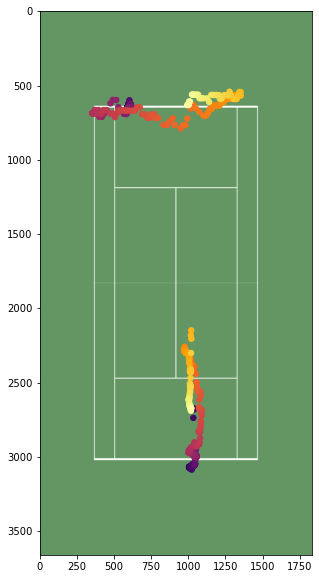

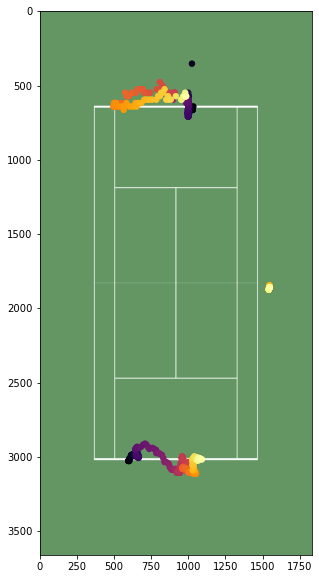

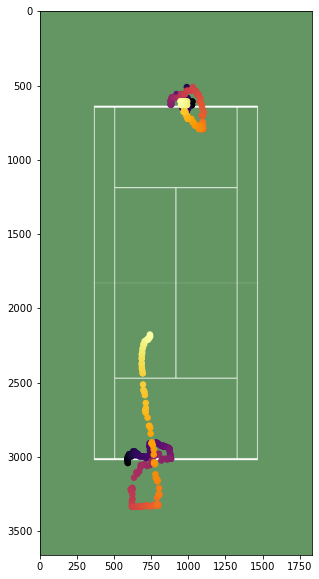

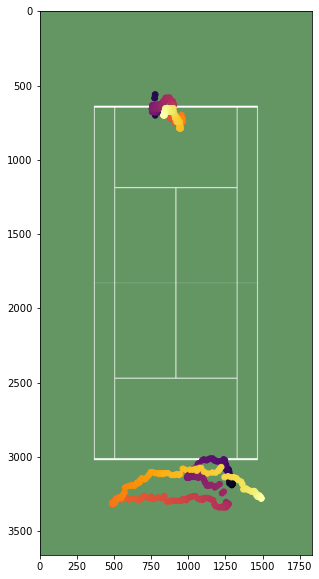

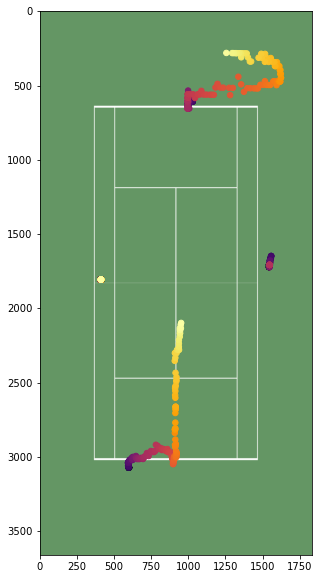

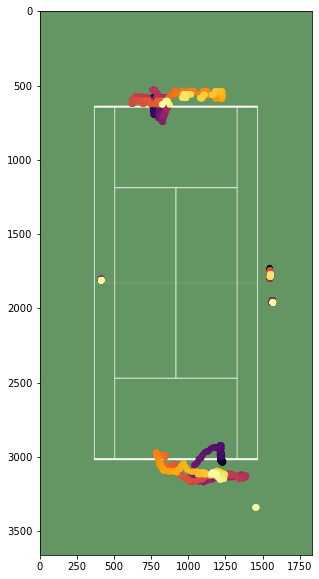

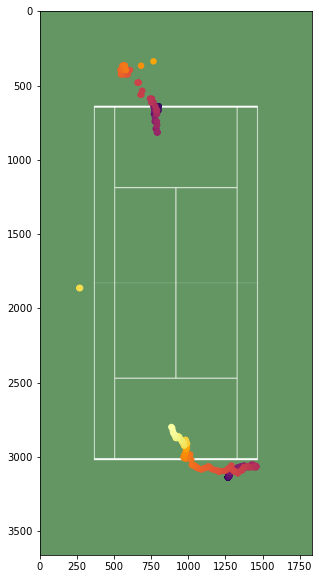

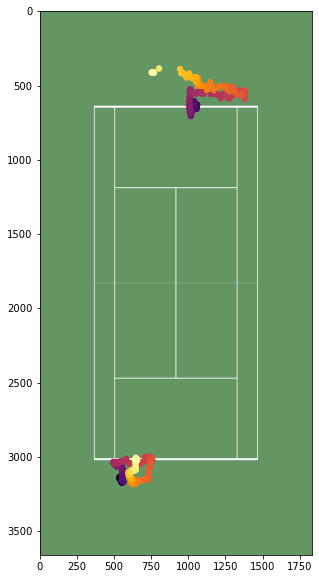

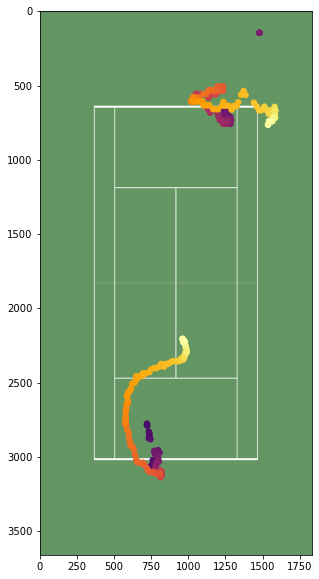

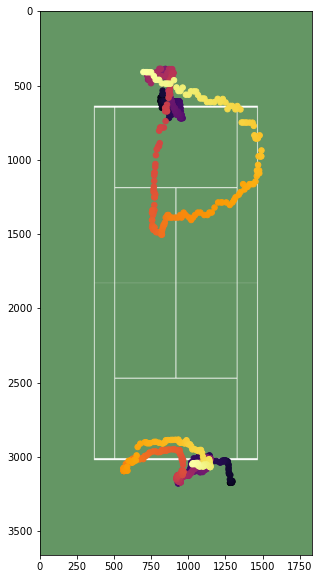

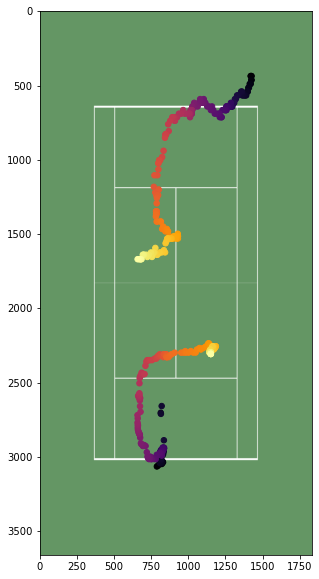

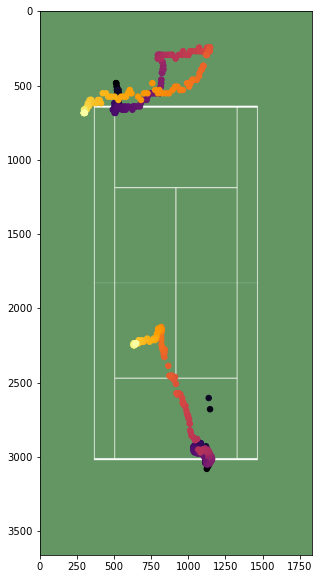

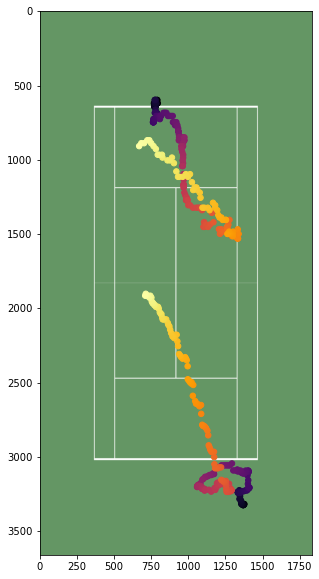

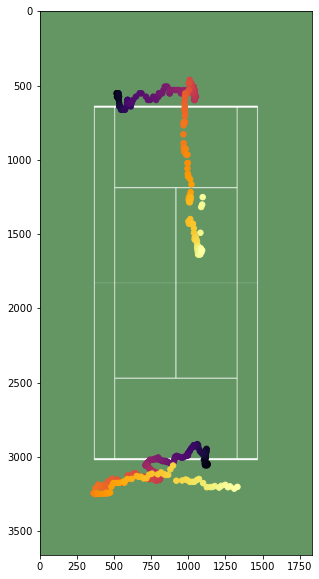

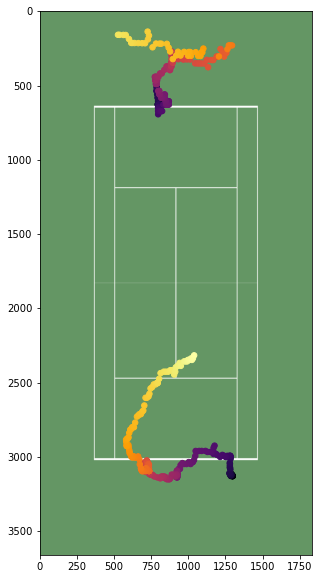

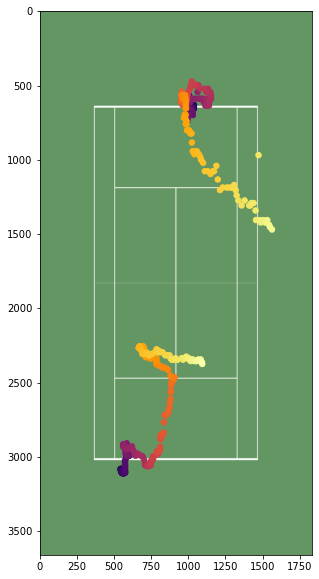

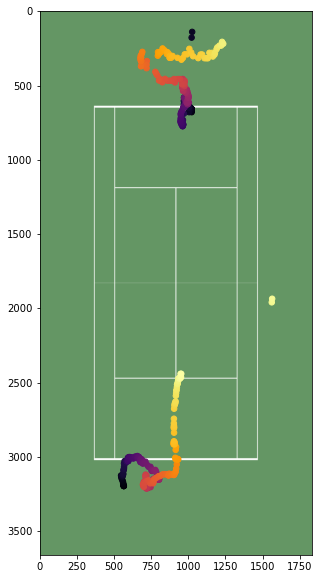

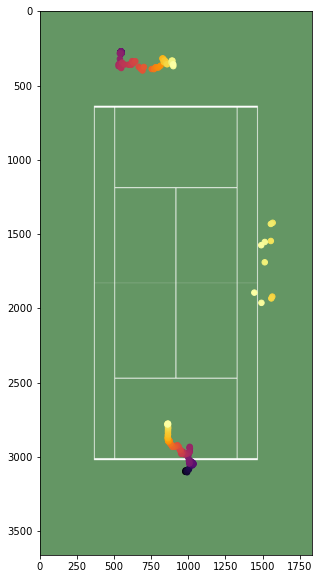

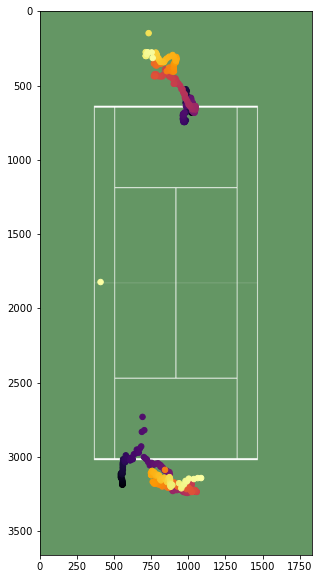

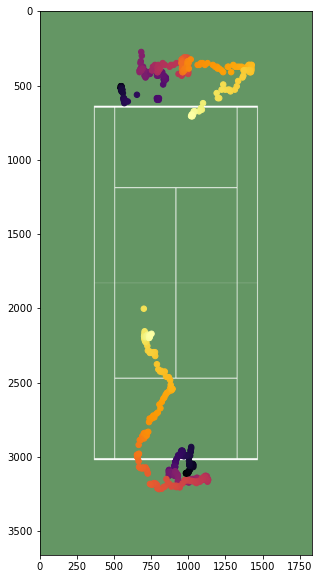

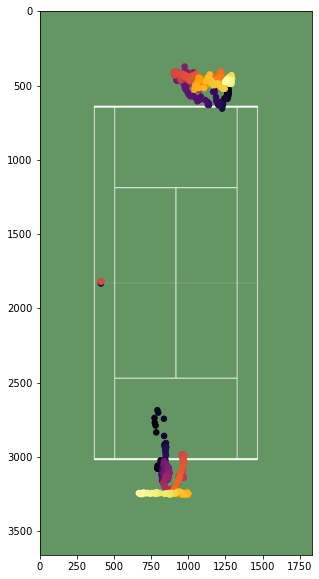

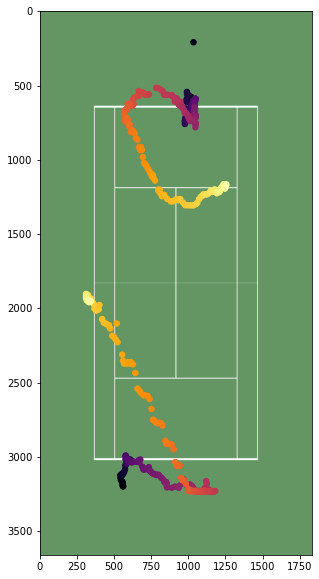

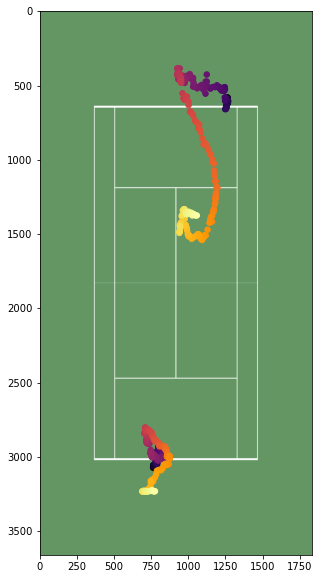

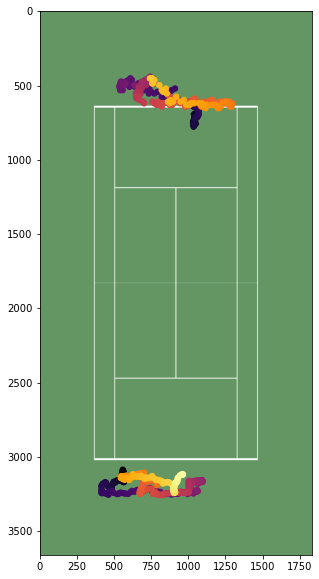

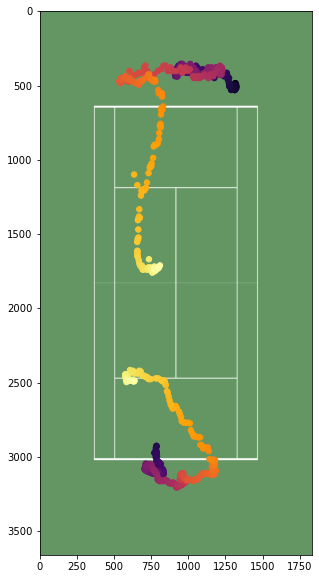

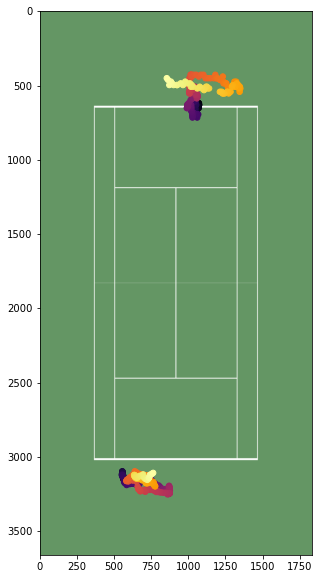

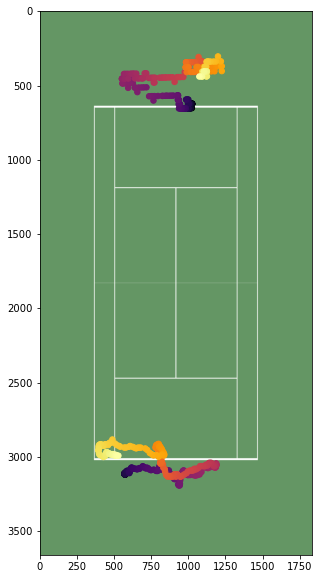

In [7]:
for i in allRall['matchID'].unique():
    plotTennis(allRall, i)

# Identify each player using Euclidean distance

This needed to be done to get rid of the vast number of umpires and help find the player consistently

In [8]:
mallRall = allRall.copy(deep=True)

for i in mallRall['matchID'].unique():    
    #separate each side of court out
    thisMatch = mallRall[mallRall['matchID']==i]  
    fsFar = thisMatch[thisMatch['Court']==1]
    fsClose = thisMatch[thisMatch['Court']==0]
    
    #count of number of players in each frame 
    countFar = fsFar['frame_id'].value_counts()
    countClose = fsClose['frame_id'].value_counts()
    #identifying frames with more than one player detected on each side of court
    frameFar = countFar[countFar >1].index.values
    frameClose = countClose[countClose >1].index.values
    
    #loop over each problem frame index number
    for j in frameFar:
        issueFar = fsFar[(fsFar['frame_id']==j)] 
        farIndex = issueFar.sort_values(by=['farEuc','score'], ascending = [True, False]).index[1:] #sort_values(['farBL', 'score'])
        mallRall = mallRall.drop(index = farIndex)
    
    for k in frameClose:
        issueClose = fsClose[(fsClose['frame_id']==k)]  #identify rows in close court    
        closeIndex = issueClose.sort_values(by=['closeEuc','score'], ascending = [True, False]).index[1:] #sort_values(['closeBL', 'score'])
        mallRall = mallRall.drop(index = closeIndex)
        
        

In [9]:
#Drop euclidean columns

mallRall = mallRall.drop(['farEuc','closeEuc'], axis =1)

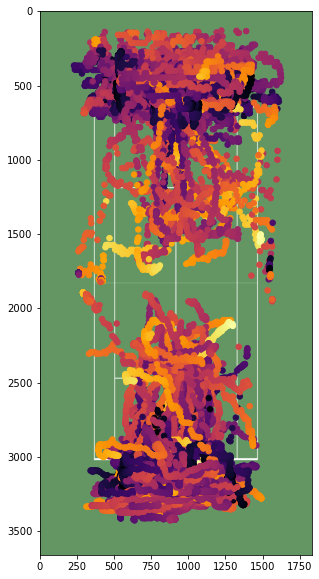

In [10]:
plotAll(mallRall)

<ipython-input-1-952a4e3d0e46>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,10))


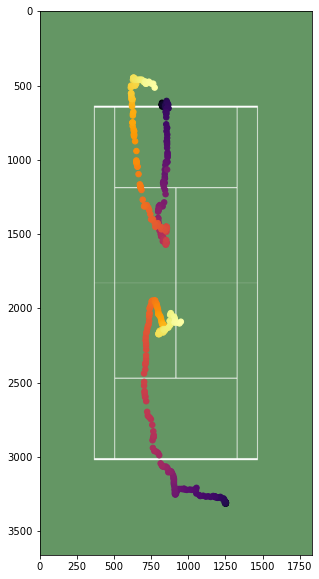

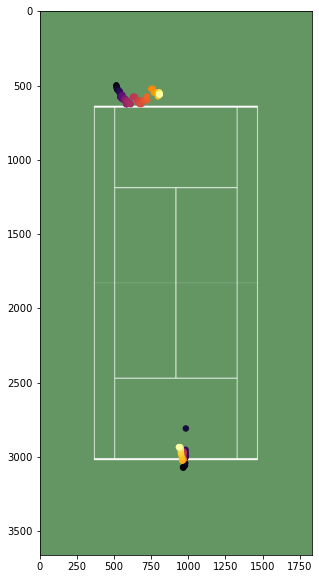

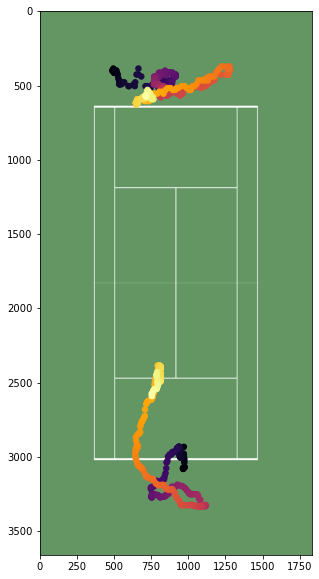

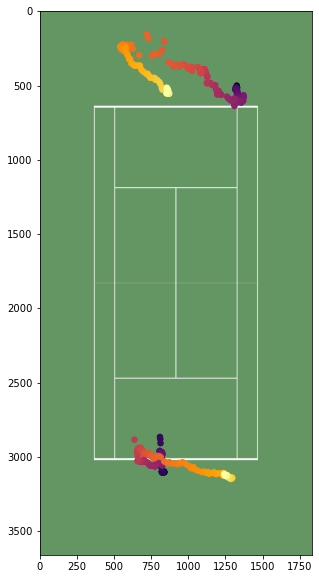

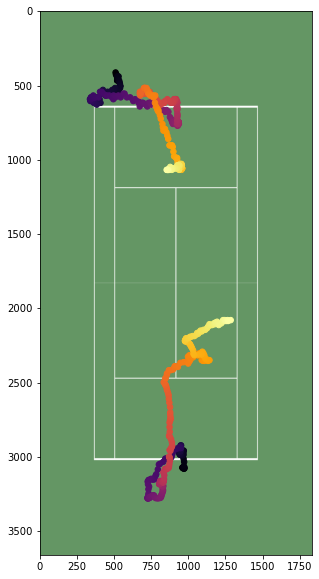

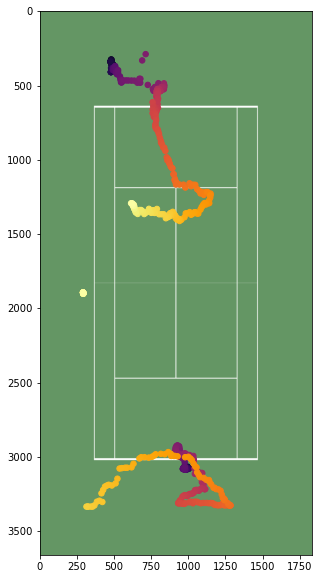

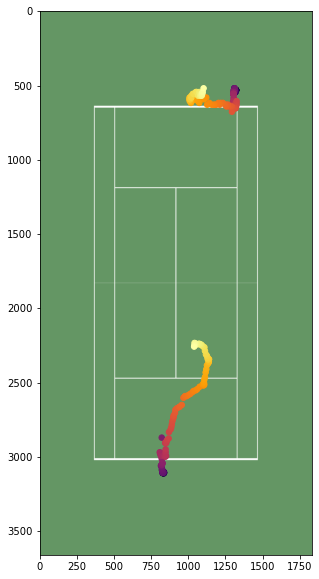

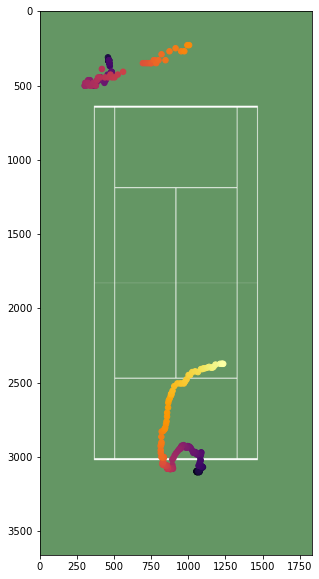

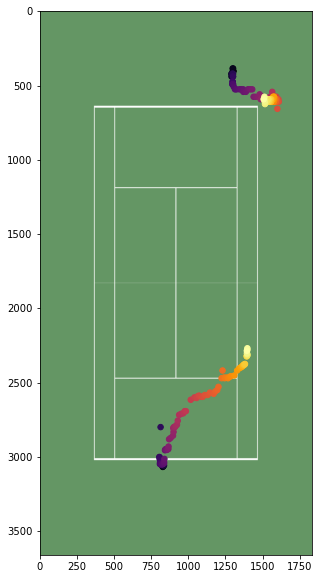

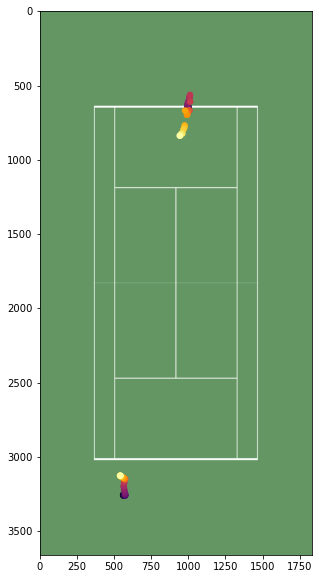

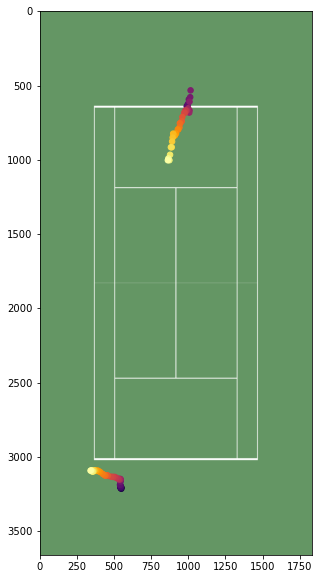

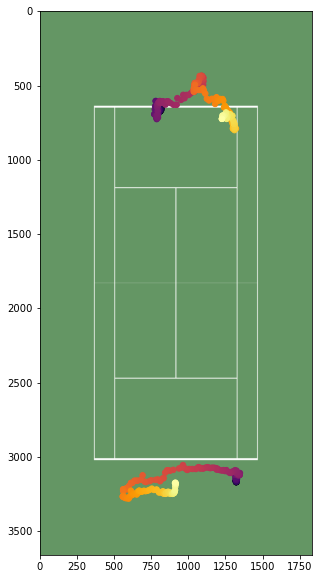

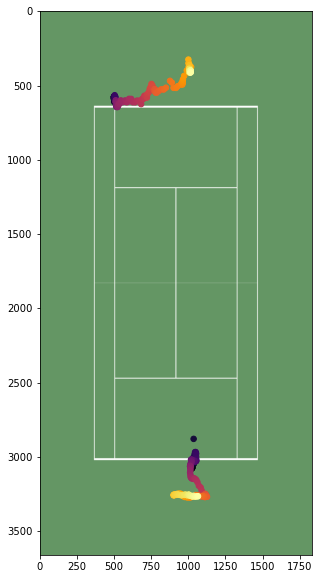

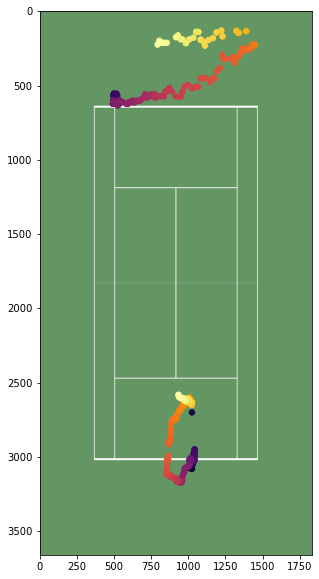

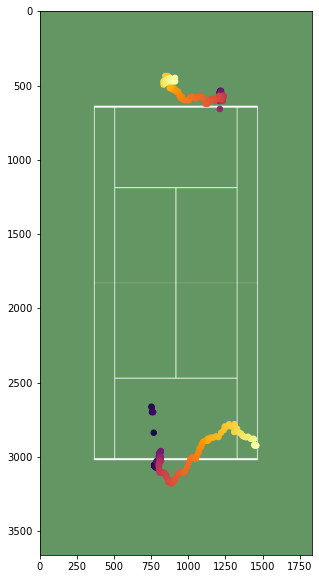

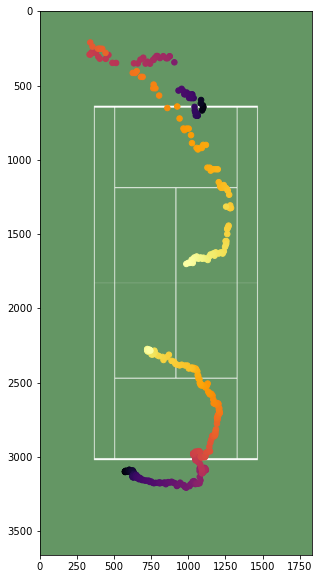

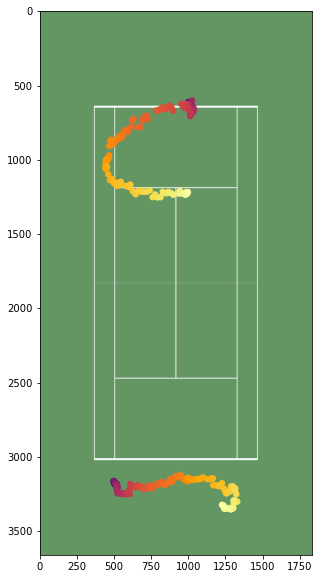

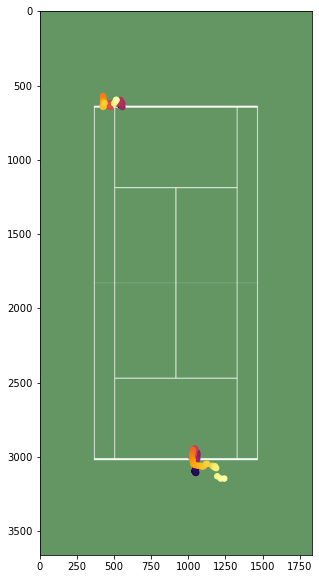

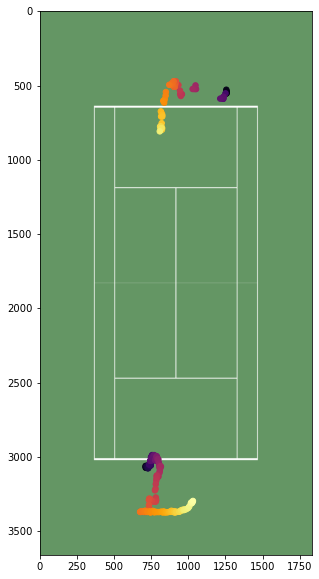

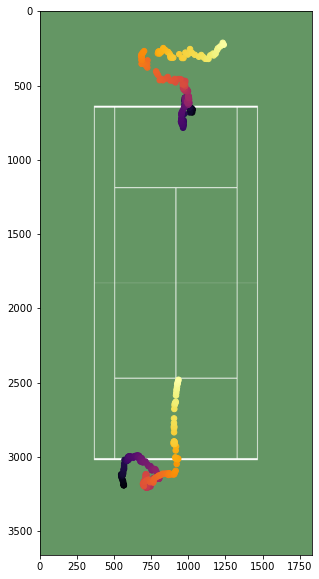

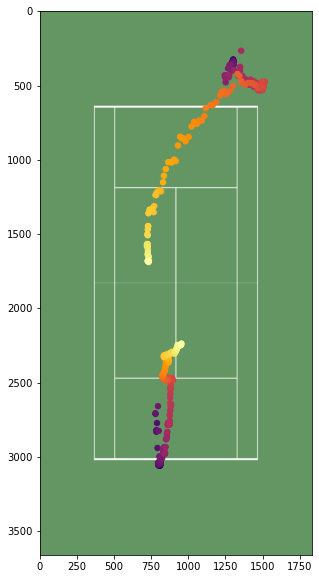

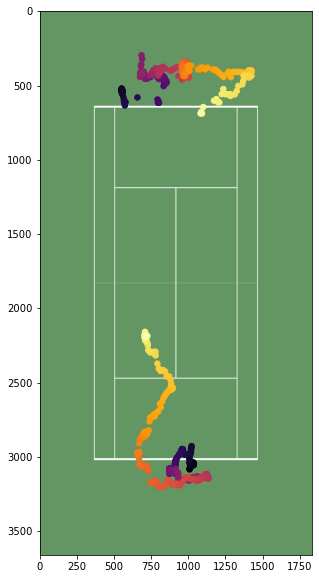

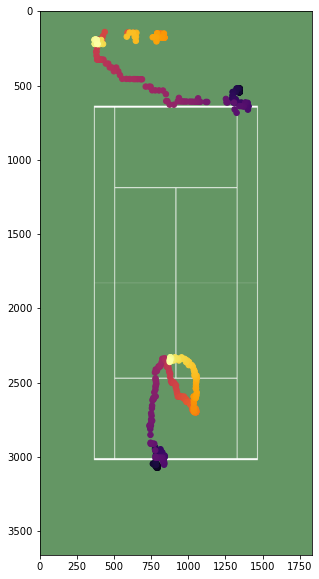

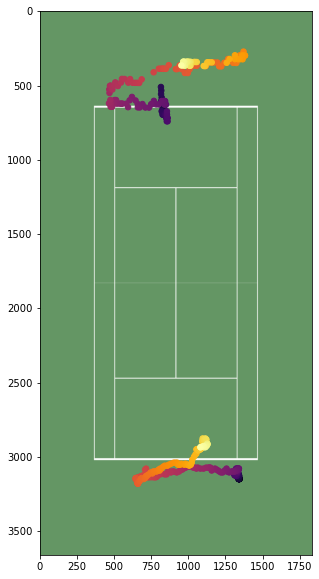

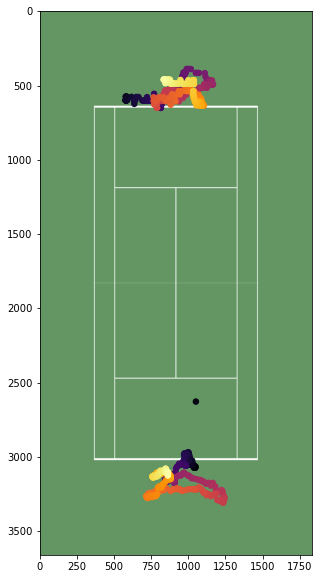

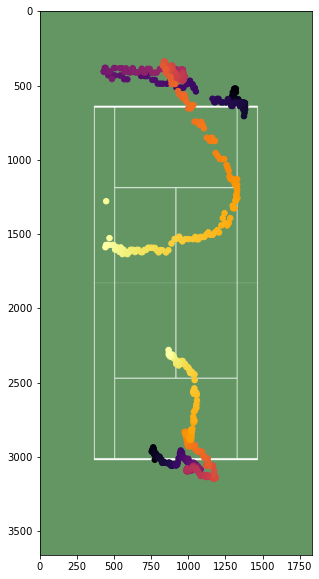

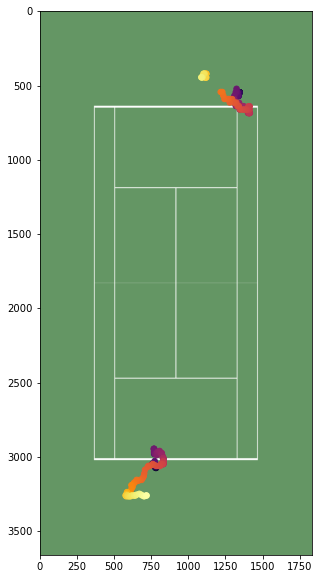

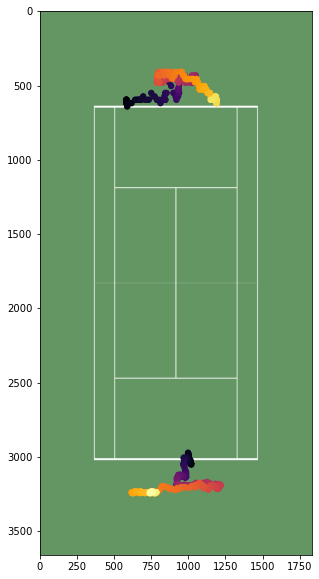

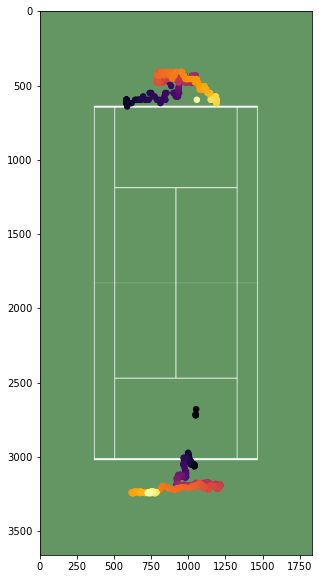

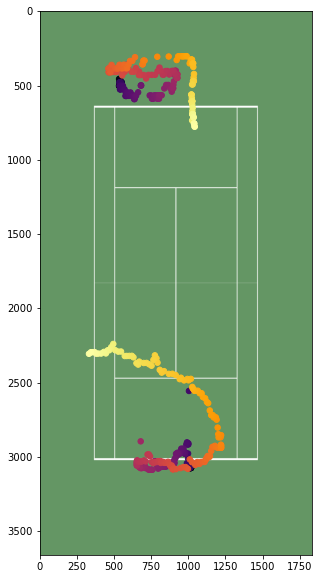

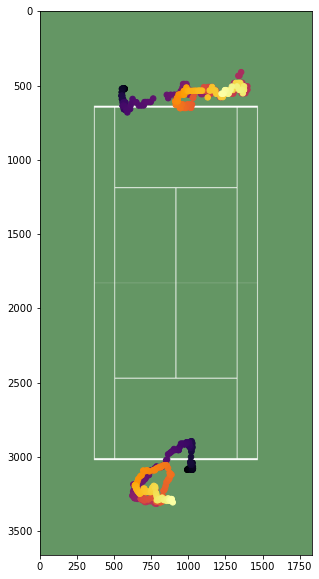

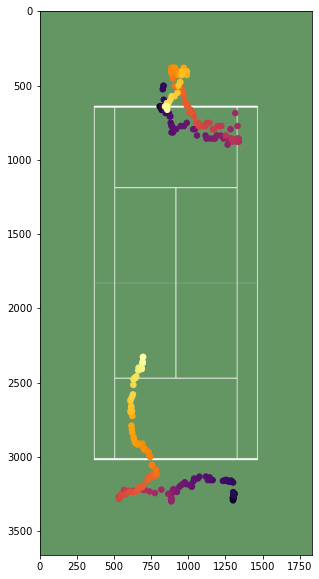

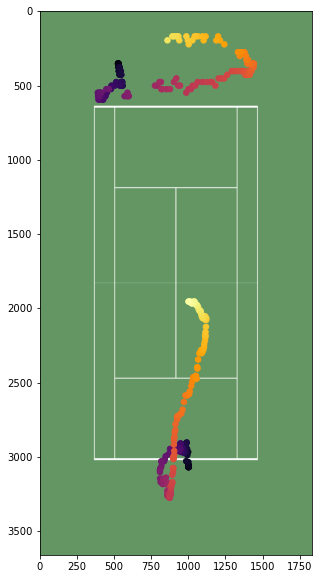

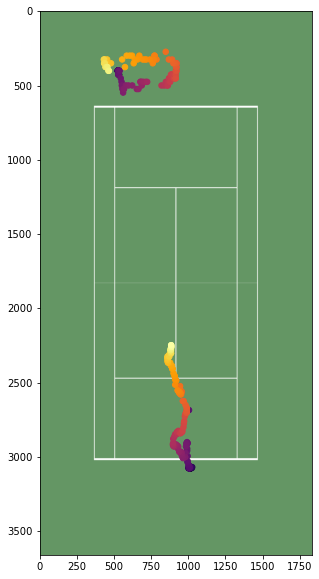

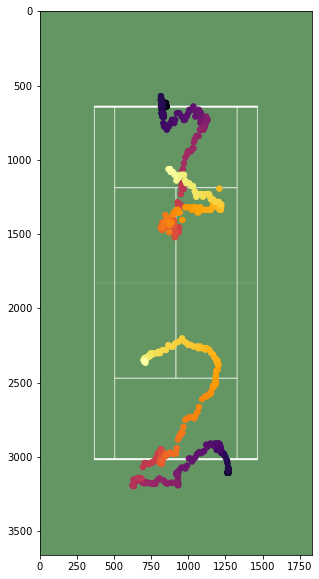

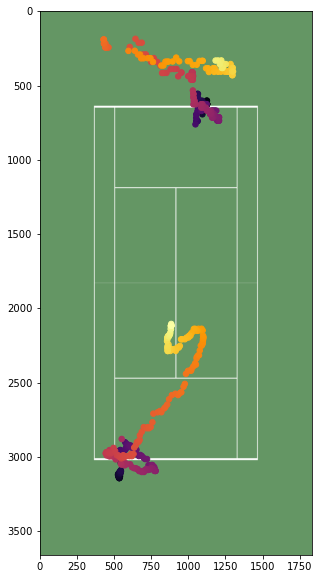

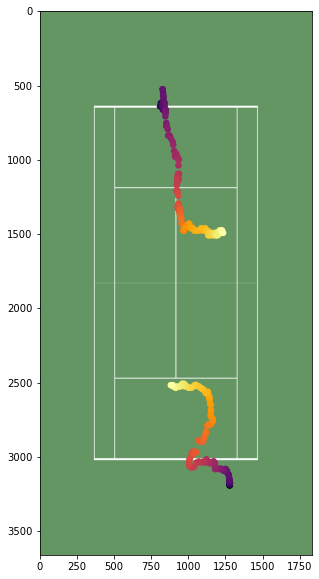

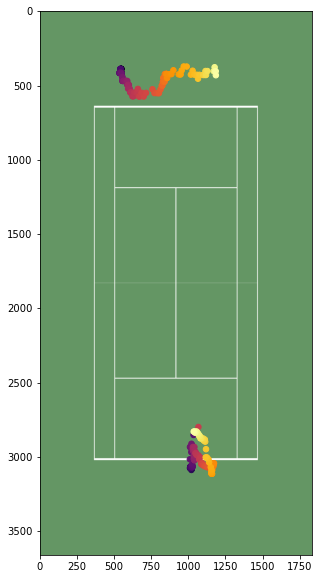

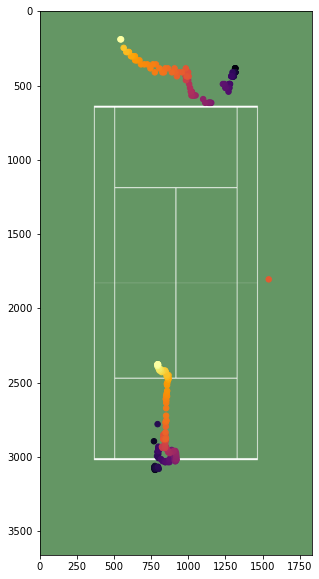

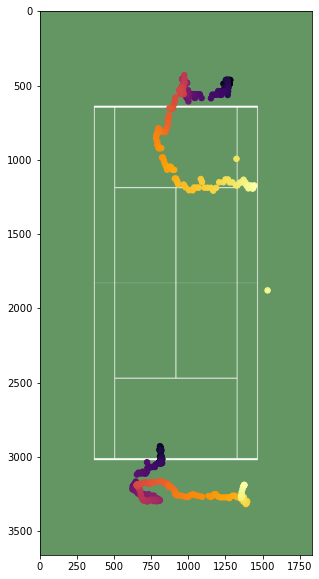

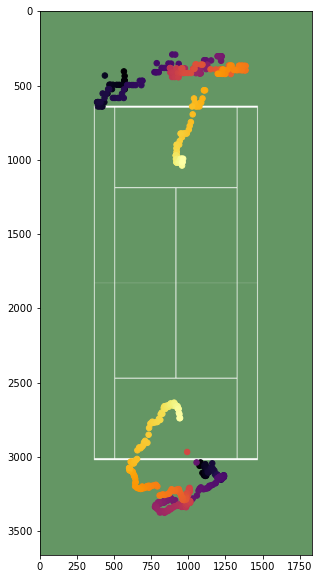

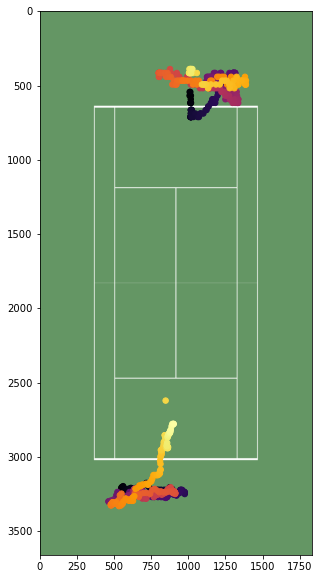

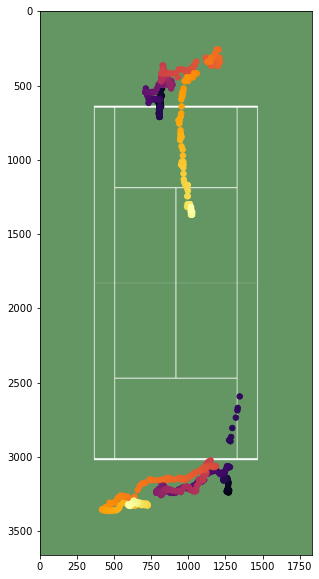

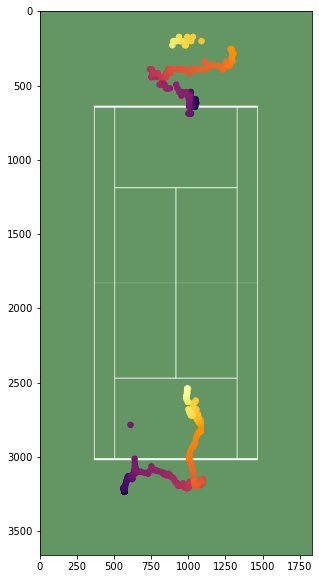

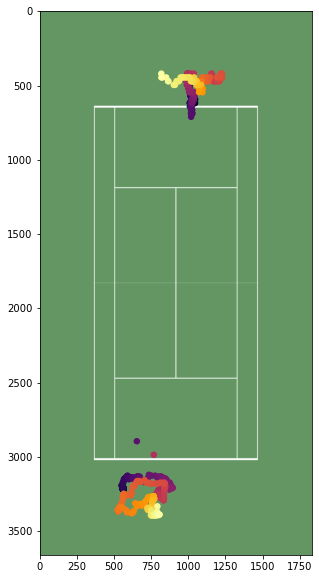

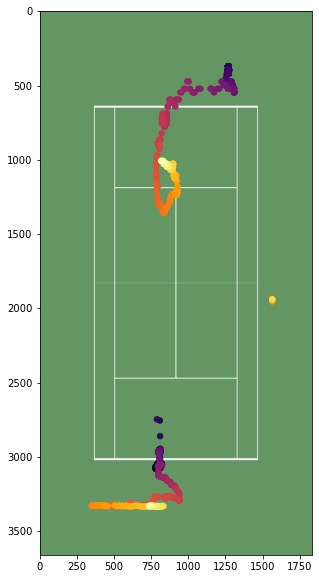

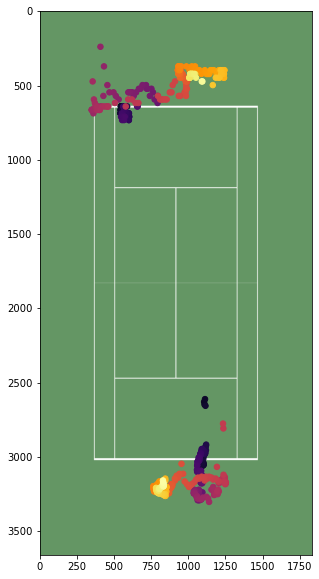

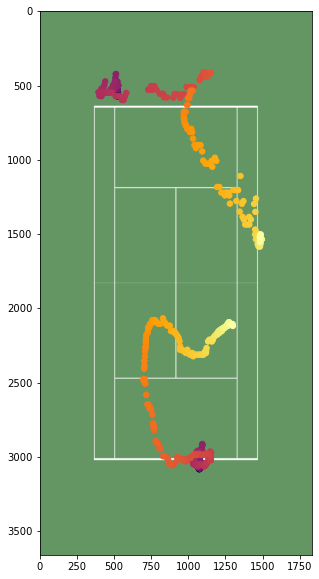

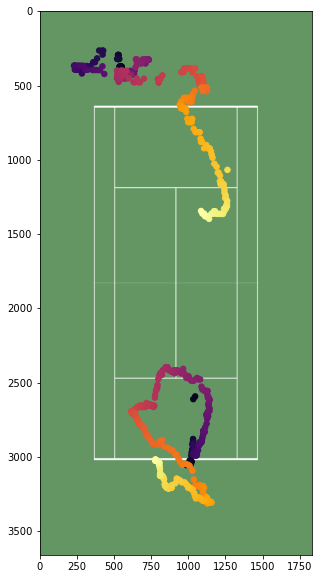

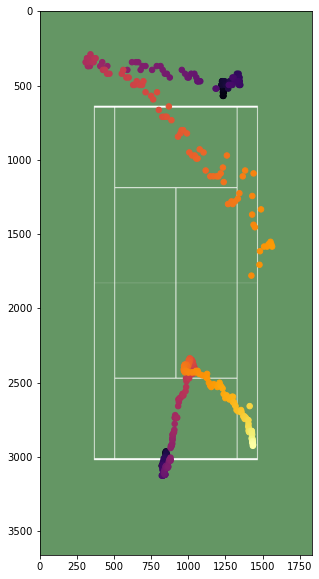

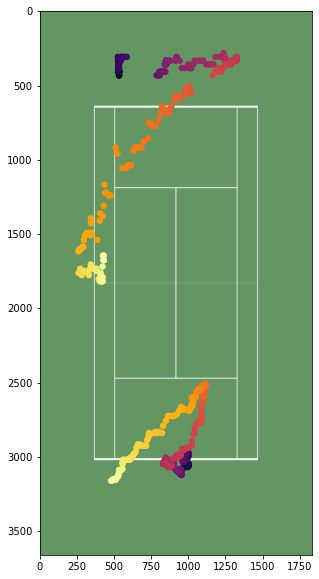

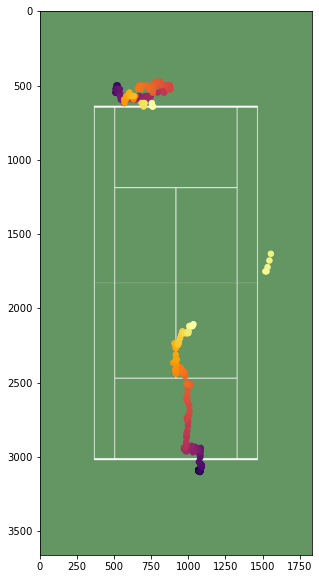

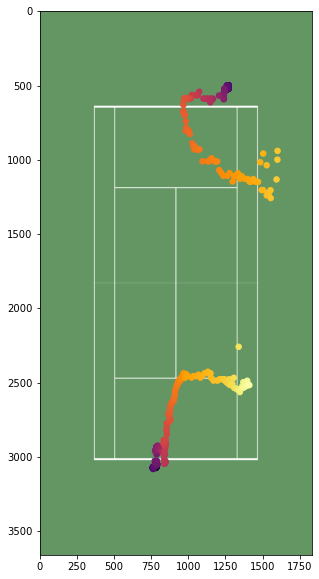

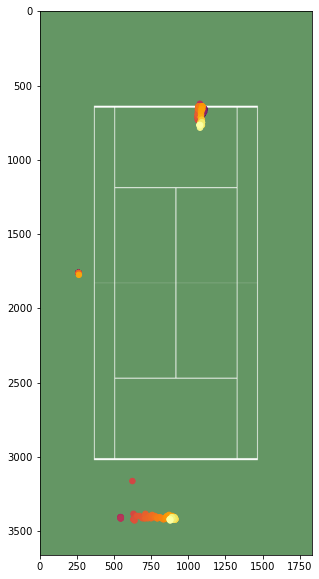

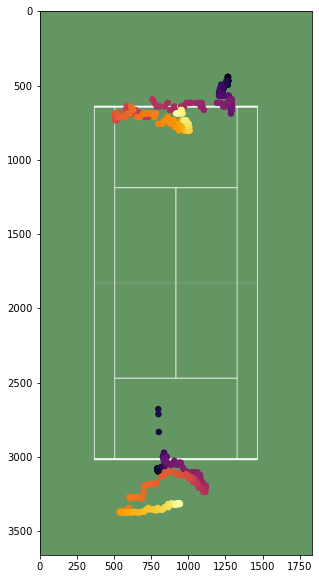

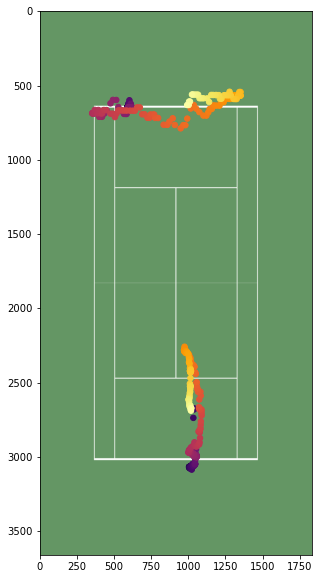

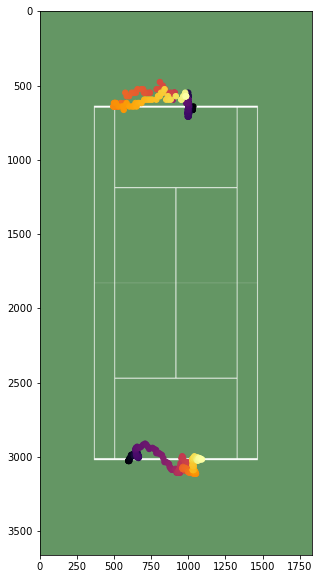

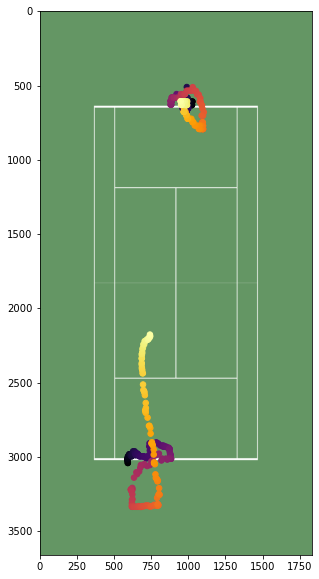

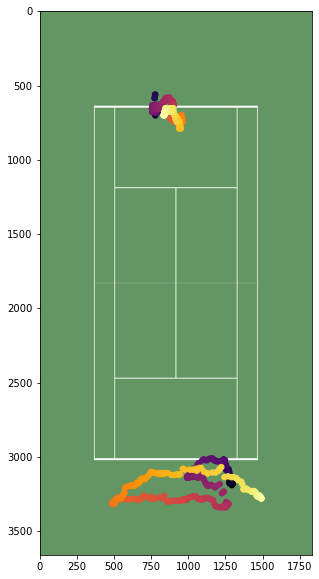

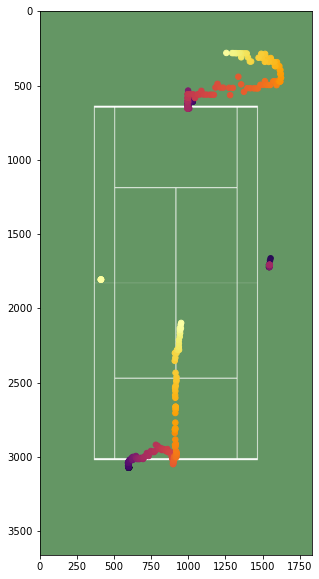

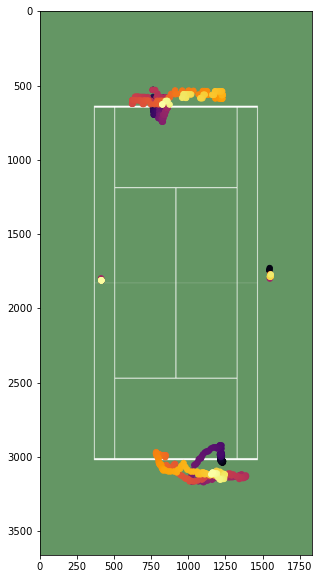

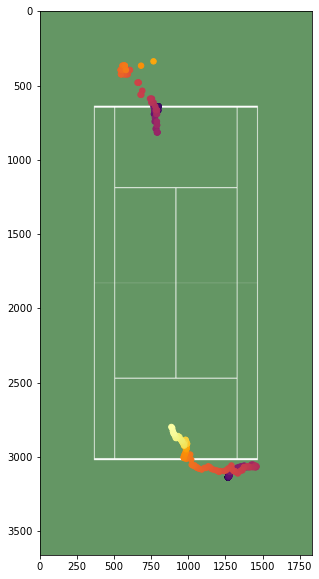

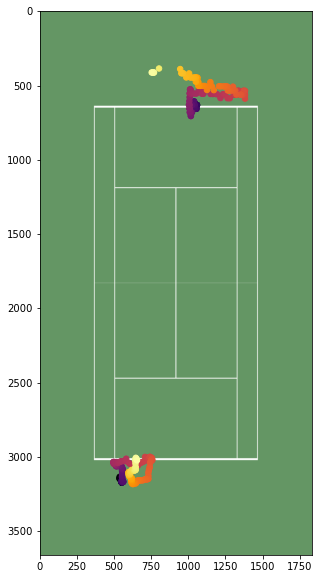

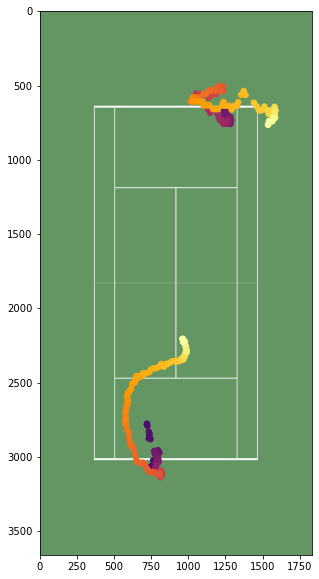

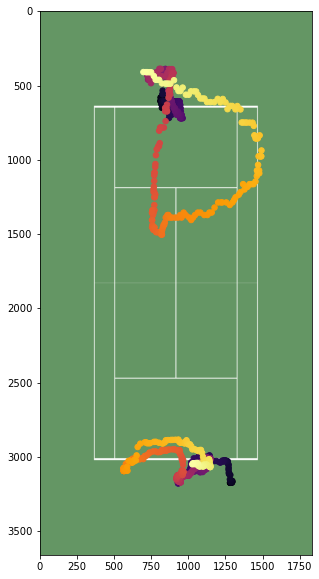

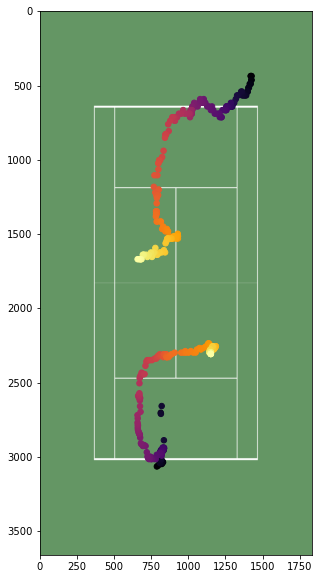

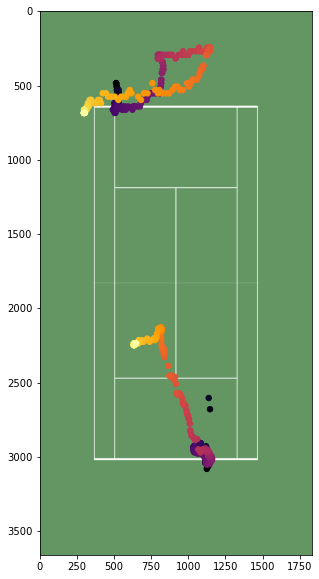

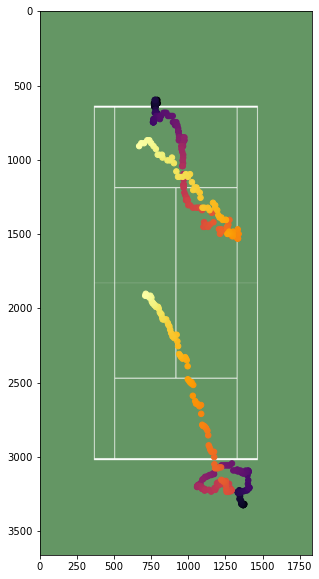

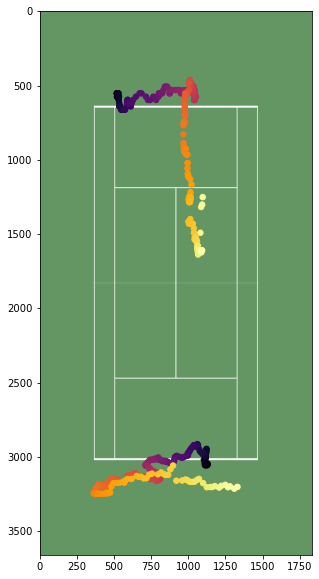

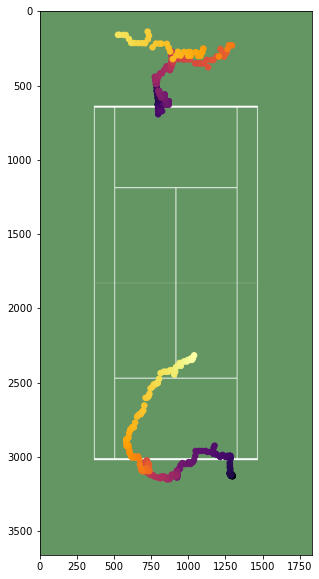

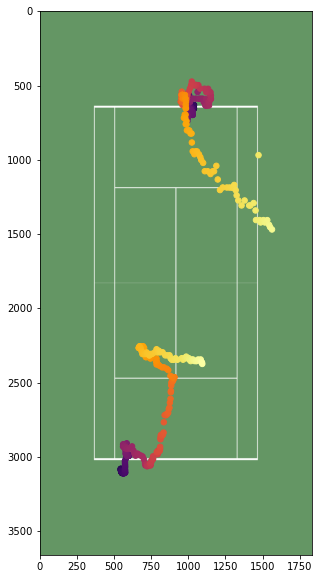

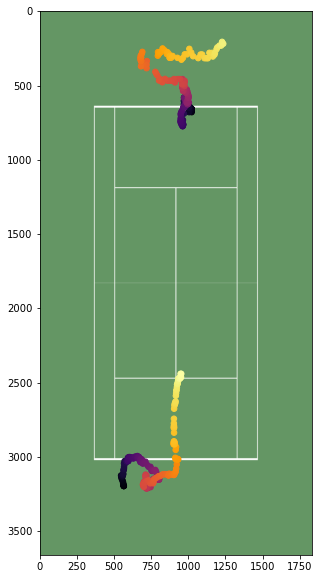

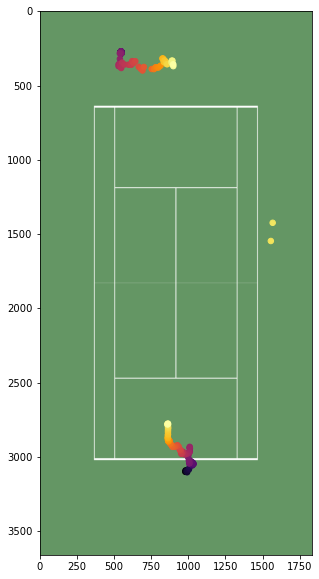

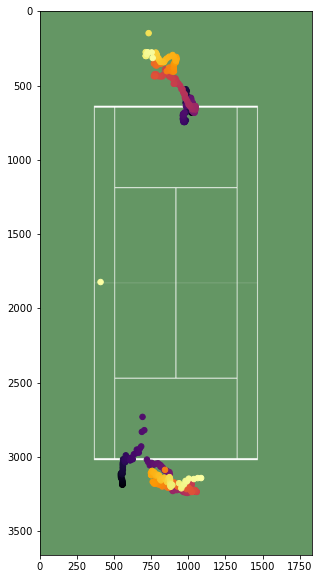

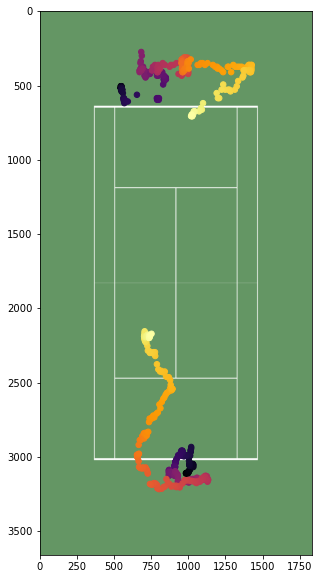

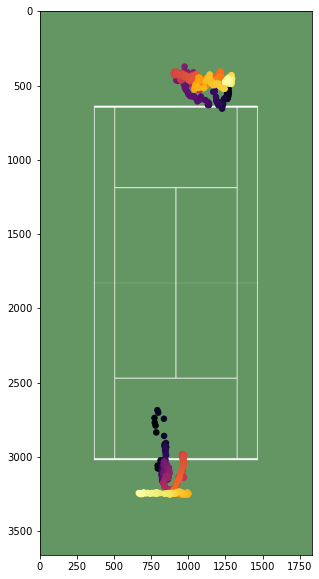

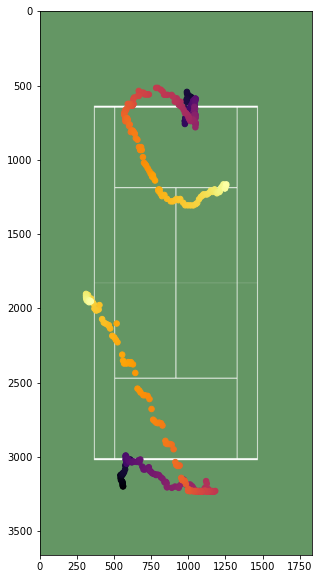

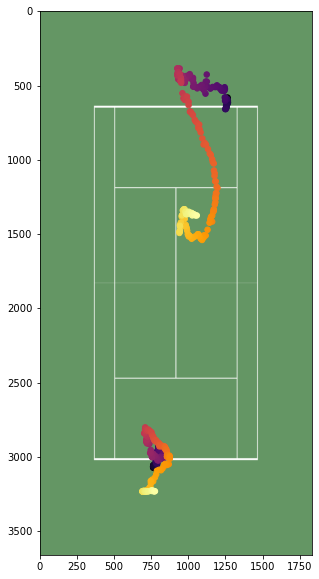

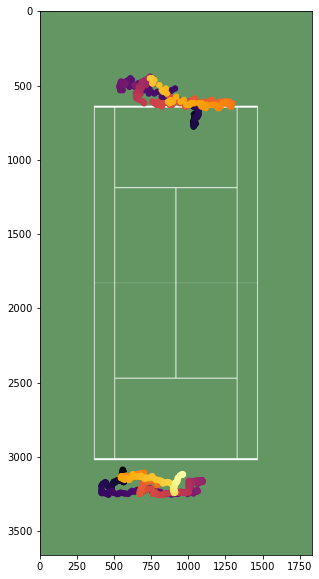

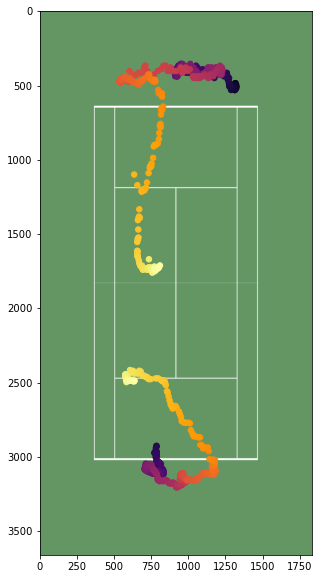

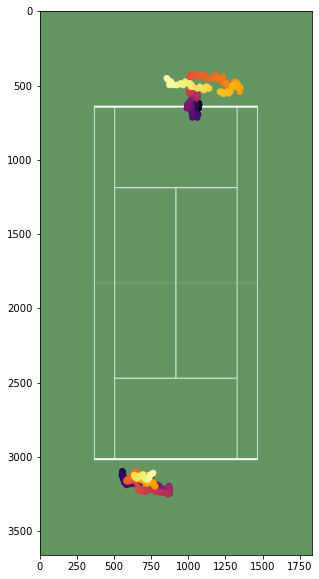

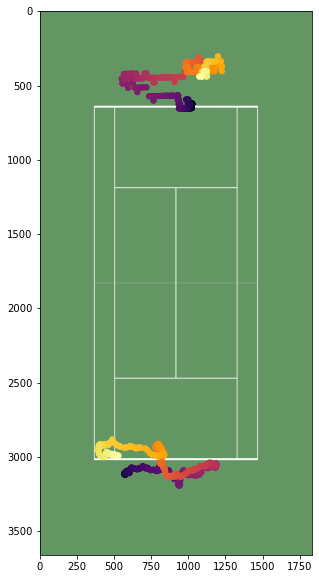

In [11]:
for i in mallRall['matchID'].unique():
    plotTennis(mallRall, i)

### Finding out how many frames are missing in each rally

In [18]:
print("Rallies where player is missing in first frame")


closeCourt = mallRall[mallRall['Court']==0]
farCourt = mallRall[mallRall['Court']==1]


for i in mallRall['matchID'].unique():
    farMissing = farCourt[farCourt['matchID']==i]['frame_id'].unique()
    closeMissing = closeCourt[closeCourt['matchID']==i]['frame_id'].unique()
    rallyLen = mallRall[mallRall['matchID']==i]['frame_id'].unique().max()
    
    farArray = np.where(~(np.in1d(range(rallyLen+1),farMissing)))[0]
    closeArray = np.where(~(np.in1d(range(rallyLen+1),closeMissing)))[0]

    # For each rally, prints the number of frames missing a player
#     print("Rally No.: ", i)
#     print("Frames in the rally: ",rallyLen)
#     print("Player missing in far court: ",farArray.shape[0])
#     print("Player missing in close court: ",closeArray.shape[0])
#     print('\n')
  
    ## Rallies where there are more than 40% of frames missing
    if ((farArray.shape[0]/rallyLen) > 0.4) | ((closeArray.shape[0]/rallyLen) > 0.4):
            print("Rally No.: ", i)
            print("Frames in the rally: ",rallyLen)
            print("Player missing in far court: ",farArray.shape[0])
            print("Player missing in close court: ",closeArray.shape[0])
            print('\n')
            
    # Prints the matches where player is missing in the first frame
#     farfirst = np.in1d([0],farArray).all()
#     closefirst = np.in1d([0],closeArray).all()
    
#     if (farfirst | closefirst):
#         print(i)
#         print(farArray.shape)
#         print(closeArray.shape)
#         print('\n')

Rallies where player is missing in first frame
Rally No.:  8
Frames in the rally:  165
Player missing in far court:  77
Player missing in close court:  3


Rally No.:  21
Frames in the rally:  291
Player missing in far court:  139
Player missing in close court:  1


Rally No.:  23
Frames in the rally:  73
Player missing in far court:  34
Player missing in close court:  0


Rally No.:  24
Frames in the rally:  161
Player missing in far court:  101
Player missing in close court:  4


Rally No.:  75
Frames in the rally:  163
Player missing in far court:  3
Player missing in close court:  85


Rally No.:  85
Frames in the rally:  208
Player missing in far court:  121
Player missing in close court:  0




From all the rallies, there are 4 rallies (8, 21, 37, 75) missing a player in the first five frames of the rally. Manually obtain the approximate coordinates for these rallies and impute these values. 

Additonally rallies 8, 21, 23, 24, 75, 85 have over 40% of one player's coordinate missing. These rallies also include 3 of the rallies with missing players in the first five frames. Based on such a high number of frames missing, imputing missing values would not lead to valuable information. Removing these would be a better outcome. 

### Removing frames with too many missing values

In [19]:
mallRall = mallRall[~mallRall['matchID'].isin([8,21,23,24,75,85])]

### Adding frames for rally 37

In [20]:
new37 = farCourt[farCourt['matchID']==37]

for i in range(8):
    copy37 = new37.iloc[0].copy()
    copy37.loc['frame_id'] = i
    mallRall = mallRall.append(copy37)   

### Imputing player location for first 5 frames

This step is important as it allows us to create a bounding box from the beginning of the rally through to the end and identify coordinates where outliers are present

In [21]:

firstfive = mallRall[mallRall['frame_id']<5]

closefive = firstfive[firstfive['Court']==0]
farfive = firstfive[firstfive['Court']==1]

for i in firstfive['matchID'].unique():
    close = closefive[closefive['matchID']==i]
    far = farfive[farfive['matchID']==i]

    if len(close)<5:
        #array of current frame_no [1,2,5]
        currentclose = close['frame_id'].unique()
        #array of missing frame_no [3,4]
        missing =np.where(~np.in1d(range(5),currentclose))[0]     
        avgX = close['fX'].mean()
        avgY = close['fY'].mean()
        for j in missing:
            newclose = close.iloc[0].copy()
            newclose.loc['frame_id'] = j
            newclose.loc['fX'] = avgX
            newclose.loc['fY'] = avgY
            mallRall = mallRall.append(newclose) 
        
    if len(far)<5:
        currentfar = far['frame_id'].unique()
        missing =np.where(~np.in1d(range(5),currentfar))[0]
        avgX = far['fX'].mean()
        avgY = far['fY'].mean()
        for j in missing:
            newfar = far.iloc[0].copy()
            newfar.loc['frame_id'] = j
            newfar.loc['fX'] = avgX
            newfar.loc['fY'] = avgY
            mallRall = mallRall.append(newfar) 
 


In [22]:
mallRall = mallRall.reset_index()
mallRall = mallRall.drop('index', axis =1 )

In [23]:
#checking to make sure every rally has 
firstfive = mallRall[mallRall['frame_id']<5]

for i in firstfive['matchID'].unique():
    if len(firstfive[firstfive['matchID']==i]) <10:
        print(i)

In [24]:
# reset order and closeCourt farCourt
mallRall = mallRall.sort_values(['matchID', 'frame_id'])
closeCourt = mallRall[mallRall['Court']==0]
farCourt = mallRall[mallRall['Court']==1]

### Using euclidean distance to identify outlier/error rows still in the list

All rallies have a xy coordinate for each player in the first 5 frames. From this, we use a euclidean perimeter to identify rows that have a high chance of being an error row and remove them from the df. Different euclidean perimeter values have been used for the players in the far and close court. This is because the tracking of the close court player is more accurate and we can safely reduce the euclidean perimeter without risking removal of a correct row.

In [25]:
harcourt = farCourt.copy(deep=True)
harclose = closeCourt.copy(deep =True)

In [26]:

for i in harcourt['matchID'].unique():
    #for each rally, obtain the xy coordinates of the first frame
    rallyFar = harcourt[harcourt['matchID']==i]
    startxFar = rallyFar.loc[rallyFar['frame_id']==0,'fX'].values[0]
    startyFar = rallyFar.loc[rallyFar['frame_id']==0,'fY'].values[0]
    
    rallyClose = harclose[harclose['matchID']==i]
    startxClose = rallyClose.loc[rallyClose['frame_id']==0,'fX'].values[0]
    startyClose = rallyClose.loc[rallyClose['frame_id']==0,'fY'].values[0]
    
    for idx, row in harcourt[harcourt['matchID']==i].iterrows():
        
        #euclidean distance between this row and previous row
        eucDistance = np.sqrt((row['fX'] - startxFar)**2 + (row['fY'] - startyFar)**2)
        
        # eucDistance over 250(change of 250 in one frame is equivalent to over 50m/s)
        if eucDistance > 250:
            harcourt = harcourt.drop(index= idx)
        else:
            startxFar = row['fX']
            startyFar = row['fY']
         
    for idx, row in harclose[harclose['matchID']==i].iterrows():
        
        #euclidean distance between this row and previous row
        eucDistance = np.sqrt((row['fX'] - startxClose)**2 + (row['fY'] - startyClose)**2)
        
        # eucDistance over 100(change of 100 in one frame equivalent to 25m/s)
        if eucDistance > 200:
            harclose = harclose.drop(index= idx)
        else:
            startxClose = row['fX']
            startyClose = row['fY']       

### Imputation of missing rows

We identify the frames where the player is missing and impute an x and y coordinate using the player information from the previous frame and the future frame. 

In [27]:
#find number of missing frames
harcourt['misB'] = harcourt['frame_id'] - harcourt['frame_id'].shift()
harclose['misB']= harclose['frame_id'] - harclose['frame_id'].shift()

#Change all first frame misB and euc to 0
harcourt.loc[harcourt['frame_id']==0,'misB']= 0
harclose.loc[harclose['frame_id']==0,'misB']= 0

In [28]:
#find x & y difference between row and previous row
harcourt['dX'] = (harcourt['fX'] - harcourt['fX'].shift())*-1
harcourt['dY'] = (harcourt['fY'] - harcourt['fY'].shift())*-1
harclose['dX'] = (harclose['fX'] - harclose['fX'].shift())*-1
harclose['dY'] = (harclose['fY'] - harclose['fY'].shift())*-1

#Change all first frame misB and euc to 0
harcourt.loc[harcourt['frame_id']==0,'dX']= 0
harcourt.loc[harcourt['frame_id']==0,'dY']= 0
harclose.loc[harclose['frame_id']==0,'dX']= 0
harclose.loc[harclose['frame_id']==0,'dY']= 0

In [29]:
completeFar = harcourt.copy(deep = True)
completeClose = harclose.copy(deep = True)

In [30]:
for i in harcourt['matchID'].unique():   


    for idx, row in harcourt[harcourt['matchID']==i].iterrows():
        if row['misB']>1:
            divX = row['dX']/row['misB']
            divY = row['dY']/row['misB']
            
            for j in range(1,int(row['misB'])):
                newRow = row.copy()
                newFrameNo = row['frame_id'] - j
                newX = (divX * j) + row['fX']
                newY = (divY * j) + row['fY']
                
                newRow['frame_id'] = newFrameNo
                newRow['fX'] = newX
                newRow['fY'] = newY
                #append to copied DF
                completeFar = completeFar.append(newRow)
                
    for idx, row in harclose[harclose['matchID']==i].iterrows():
        if row['misB']>1:
            divX = row['dX']/row['misB']
            divY = row['dY']/row['misB']
            
            for j in range(1,int(row['misB'])):
                newRow = row.copy()
                newFrameNo = row['frame_id'] - j
                newX = (divX * j) + row['fX']
                newY = (divY * j) + row['fY']
                
                newRow['frame_id'] = newFrameNo
                newRow['fX'] = newX
                newRow['fY'] = newY
                #append to copied DF
                completeClose = completeClose.append(newRow)


In [31]:
completeFar = completeFar.sort_values(['matchID', 'frame_id'])
completeFar = completeFar.reset_index()
completeFar = completeFar.drop(['index','class', 'score','misB','dX','dY'], axis =1 )

completeClose = completeClose.sort_values(['matchID', 'frame_id'])
completeClose = completeClose.reset_index()
completeClose = completeClose.drop(['index','class', 'score','misB','dX','dY'], axis =1 )

### Checking that imputation of values has been successful

No outputted match number means that every rally has two player coordinates for each frame.

In [32]:
#Check all rows are filled
for i in completeFar['matchID'].unique():
    counter = completeFar[completeFar['matchID']==i]
    noRows = len(counter)
    noFrames = counter['frame_id'].unique().max()+1
    
    if noRows != noFrames:
        print(i)

In [33]:
for i in completeClose['matchID'].unique():
    counter = completeClose[completeClose['matchID']==i]
    noRows = len(counter)
    noFrames = counter['frame_id'].unique().max()+1
    
    if noRows != noFrames:
        print(i)

### Rotate the coordinates of the farcourt data so that it is in the close court position. This will be useful for when extracting data based on win loss

In [34]:
finFar = completeFar.copy(deep=True)
finClo = completeClose.copy(deep=True)
finFar['fX'] = finFar.apply(lambda row: rotate(row.loc[['fX','fY']],degrees=180)[0],axis=1)
finFar['fY'] = finFar.apply(lambda row: rotate(row.loc[['fX','fY']],degrees=180)[1],axis=1)

In [35]:
allP = finFar.append(finClo)
allP = allP.reset_index()
allP = allP.drop('index', axis =1 )

### Feature Engineering

#### Calculate eucD, Lateral distance, longitude distance, Distance from Net, distance from Centre Line, 

NetLine 1829 
CentreLine 914.5

In [36]:
#Distance from net and centre lines
allP['fromNet'] = allP['fY'] - 1829
allP['fromCentre'] = abs(allP['fX'] - 914.5)



# lateral & longitudinal difference
allP['dX'] = abs(allP['fX'] - allP['fX'].shift())
allP['dY'] = abs(allP['fY'] - allP['fY'].shift())


# #Change all first frame misB and euc to 0
allP.loc[allP['frame_id']==0,'dX']= 0
allP.loc[allP['frame_id']==0,'dY']= 0

# eucdistance
allP['dist'] = allP.apply(lambda row: np.sqrt(row['dX']**2 + row['dY']**2),axis=1)

#cumulative values
allP['cumDist'] = allP.groupby(['matchID','Court'])['dist'].cumsum()
allP['cumX'] = allP.groupby(['matchID','Court'])['dX'].cumsum()
allP['cumY'] = allP.groupby(['matchID','Court'])['dY'].cumsum()


## Identifying which area of the court the player is in at row.(FrontHalf, BackHalf, BehindLine)
#Dummy variables for FrontHalf, BackHalf, BehindLine

allP['frontHalf'] = allP.apply(lambda row: 1 if row['fY']<2469 else 0,axis=1)
allP['backHalf'] = allP.apply(lambda row: 1 if (row['fY']>2469) &(row['fY']<3017) else 0,axis=1)
allP['behindLine'] = allP.apply(lambda row: 1 if row['fY']>3017 else 0,axis=1)

In [53]:
totalDist = allP.groupby(['matchID','Court'])['cumDist'].max()/(allP.groupby(['matchID','Court'])['frame_id'].max()+1)
vertDist = allP.groupby(['matchID','Court'])['cumY'].max()/(allP.groupby(['matchID','Court'])['frame_id'].max()+1)
horDist = allP.groupby(['matchID','Court'])['cumX'].max()/(allP.groupby(['matchID','Court'])['frame_id'].max()+1)

cDist = allP.groupby(['matchID','Court'])['cumDist'].max()
cvert = allP.groupby(['matchID','Court'])['cumY'].max()
chor = allP.groupby(['matchID','Court'])['cumX'].max()

rallyLen = allP.groupby(['matchID','Court'])['frame_id'].max()

In [55]:
# For each player, calculating the percentage of a rally spent in the three areas of the court.

frontHalf = allP.groupby(['matchID','Court'])['frontHalf'].sum() / (allP.groupby(['matchID','Court'])['frame_id'].max()+1)

backHalf = allP.groupby(['matchID','Court'])['backHalf'].sum() / (allP.groupby(['matchID','Court'])['frame_id'].max()+1)

behindLine = allP.groupby(['matchID','Court'])['behindLine'].sum() / (allP.groupby(['matchID','Court'])['frame_id'].max()+1)

sections = pd.concat([frontHalf,backHalf, behindLine, rallyLen],axis=1)

sections.rename(columns = {0:'frontHalf', 1:'backHalf', 2:'behindLine', 'frame_id': 'rallyLength'}, inplace = True)
sections = sections.reset_index()


sections



matchID  Court  frontHalf  backHalf  behindLine  rallyLength
0          1      0   0.450893  0.116071    0.433036          223
1          1      1   0.361607  0.352679    0.285714          223
2          2      0   0.000000  0.800000    0.200000           59
3          2      1   0.000000  0.000000    1.000000           59
4          3      0   0.095710  0.316832    0.587459          302
..       ...    ...        ...       ...         ...          ...
147      112      1   0.175287  0.080460    0.744253          347
148      113      0   0.000000  0.000000    1.000000          218
149      113      1   0.000000  0.191781    0.776256          218
150      120      0   0.000000  0.328125    0.671875          319
151      120      1   0.000000  0.100000    0.900000          319

[152 rows x 6 columns]

### Calculate Accleration

In [56]:
temp=allP.groupby(['matchID','Court'])['dist']
temp.head()

allP['dist'] = allP.apply(lambda row: np.sqrt(row['dX']**2 + row['dY']**2),axis=1)

In [41]:
# temp=allP.loc[allP['matchID']==1].loc[allP['Court']==1]
# acc=((temp['dist'] - temp['dist'].shift())*-1).abs()
# acc

In [57]:
acc= pd.Series()  
for i in allP['matchID'].unique():
    for j in allP['Court'].unique():
        temp=allP.loc[allP['matchID']==i].loc[allP['Court']==j]
        acc=acc.append((temp['dist'] - temp['dist'].shift())*-1).abs()
        

<ipython-input-57-7325057bc849>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  acc= pd.Series()


In [58]:
new_allP=pd.concat((allP,acc), axis=1).fillna('0')
new_allP.rename(columns={new_allP.columns[-1]: 'Acceleration'},inplace=True)
new_allP["Acceleration"] = new_allP.Acceleration.astype(float)
new_allP.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36366 entries, 0 to 36365
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   frame_id      36366 non-null  int64  
 1   fX            36366 non-null  float64
 2   fY            36366 non-null  float64
 3   matchID       36366 non-null  int64  
 4   Court         36366 non-null  int64  
 5   fromNet       36366 non-null  float64
 6   fromCentre    36366 non-null  float64
 7   dX            36366 non-null  float64
 8   dY            36366 non-null  float64
 9   dist          36366 non-null  float64
 10  cumDist       36366 non-null  float64
 11  cumX          36366 non-null  float64
 12  cumY          36366 non-null  float64
 13  frontHalf     36366 non-null  int64  
 14  backHalf      36366 non-null  int64  
 15  behindLine    36366 non-null  int64  
 16  Acceleration  36366 non-null  float64
dtypes: float64(11), int64(6)
memory usage: 5.0 MB


In [59]:
new_allP.describe()

frame_id            fX            fY       matchID         Court  \
count  36366.000000  36366.000000  36366.000000  36366.000000  36366.000000   
mean     130.983474    889.716447   3016.343154     62.794231      0.495683   
std       84.552215    229.249823    282.128230     31.883229      0.499988   
min        0.000000    205.518358   1898.626702      1.000000      0.000000   
25%       60.000000    742.714026   2980.249852     40.000000      0.000000   
50%      123.000000    875.101280   3078.769467     64.000000      0.000000   
75%      193.000000   1034.733079   3187.390709     90.000000      1.000000   
max      376.000000   1598.049515   3527.907824    120.000000      1.000000   

            fromNet    fromCentre            dX            dY          dist  \
count  36366.000000  36366.000000  36366.000000  36366.000000  36366.000000   
mean    1187.343154    185.732018      5.458045      9.504499     12.591241   
std      282.128230    136.646959      5.379796     13.582535     13.229240   
min       69.626702      0.000000      0.000000      0.000000      0.000000   
25%     1151.249852     79.979634      1.449451      0.035023      3.895582   
50%     1249.769467    144.233037      3.795579      5.786368      9.549581   
75%     1358.390709    287.754383      8.079483     13.245713     17.452329   
max     1698.907824    708.981642     58.236674    245.451149    245.697223   

            cumDist          cumX          cumY     frontHalf      backHalf  \
count  36366.000000  36366.000000  36366.000000  36366.000000  36366.000000   
mean    1520.020419    630.602889   1163.897718      0.082935      0.238629   
std     1198.095784    560.232093    911.002263      0.275787      0.426252   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%      518.976670    147.425301    426.669073      0.000000      0.000000   
50%     1313.267867    493.594117   1011.028091      0.000000      0.000000   
75%     2276.574979    975.513632   1718.749710      0.000000      0.000000   
max     6884.221516   3205.527762   5478.884649      1.000000      1.000000   

         behindLine  Acceleration  
count  36366.000000  36366.000000  
mean       0.677006      8.409271  
std        0.467627     11.810184  
min        0.000000      0.000000  
25%        0.000000      1.006869  
50%        1.000000      4.618924  
75%        1.000000     11.666381  
max        1.000000    242.333956

## Next:

Creat mean/max/min value for each footage

start building models base on mean/max/min/winner 
    
    try different models, get top 3 result
    
    fine turn the models
    
    test
    
    report writing


In [60]:
df1=pd.DataFrame()
# ins=['fromNet','fromCentre','dist','Acceleration']
for i in new_allP['matchID'].unique():
    for j in new_allP['Court'].unique():
        temp=new_allP.loc[new_allP['matchID']==i].loc[new_allP['Court']==j]
        
        #fromNet
        min_fromNet=temp['fromNet'].min()
        avg_fromNet=temp['fromNet'].mean()
        max_fromNet=temp['fromNet'].max()
        std_fromNet=temp['fromNet'].std()
            
        #'fromCentre'
        min_fromCentre=temp['fromCentre'].min()
        avg_fromCentre=temp['fromCentre'].mean()
        max_fromCentret=temp['fromCentre'].max()        
        std_fromCentret=temp['fromCentre'].std()  
        #'dist'
        
        avg_dist=temp['dist'].mean()
        max_dist=temp['dist'].max() 
        std_dist=temp['dist'].std()
        
        #'Acceleration'
        
        avg_Acceleration=temp['Acceleration'].mean()
        max_Acceleration=temp['Acceleration'].max()
        std_Acceleration=temp['Acceleration'].std()
        
        df=pd.DataFrame({"matchID":[i],"Court":[j],
               "min_fromNet":[min_fromNet],"avg_fromNet":[avg_fromNet],"max_fromNet":[max_fromNet],"std_fromNet":[std_fromNet],
               "min_fromCentre":[min_fromCentre],"avg_fromCentre":[avg_fromCentre],"max_fromCentret":[max_fromCentret], "std_fromCentret":[std_fromCentret], 
               "avg_dist":[avg_dist],"max_dist":[max_dist],"std_dist":[std_dist],
               "avg_Acceleration":[avg_Acceleration],"max_Acceleration":[max_Acceleration], "std_Acceleration":[std_Acceleration],        })
        df1=df1.append(df)

In [47]:
df1

matchID  Court  min_fromNet  avg_fromNet  max_fromNet  std_fromNet  \
0         1      1   257.303962   842.355322  1381.306329   384.882164   
0         1      0   118.382947   838.815764  1482.824234   542.643022   
0         2      1  1202.830806  1259.300150  1329.939874    32.602326   
0         2      0   978.857600  1157.642380  1241.160040    41.132159   
0         3      1  1200.101358  1334.875881  1456.258443    64.326507   
..      ...    ...          ...          ...          ...          ...   
0       112      0   585.911598  1131.157141  1374.996131   242.876617   
0       113      1  1113.496894  1270.468017  1401.308196    80.562250   
0       113      0  1266.883499  1335.433876  1422.193531    42.223827   
0       120      1  1174.285340  1353.922462  1524.811112   110.496868   
0       120      0  1053.157771  1219.870662  1362.470456    73.102111   

    min_fromCentre  avg_fromCentre  max_fromCentret  std_fromCentret  \
0        47.510460      141.997342       301.441752        88.165214   
0         1.213837      151.834926       338.524431       102.532740   
0       107.532377      260.033812       398.776271       106.736006   
0        22.166075       49.851511        69.591791        10.722623   
0         0.298514      171.547100       426.579458       114.439209   
..             ...             ...              ...              ...   
0         0.239456      142.831271       339.372116        85.757297   
0         8.322169      172.528921       435.356539       103.682961   
0        38.432208      226.598835       361.648193        99.367108   
0         3.305924      157.383887       360.817659        94.314922   
0         1.069277      216.314588       521.530054       142.399194   

     avg_dist    max_dist   std_dist  avg_Acceleration  max_Acceleration  \
0   16.396104  165.535125  18.942333         11.231880        117.154114   
0   11.850770   71.638269  10.839797          6.887676         46.048386   
0   13.190400   38.331961   9.495345          8.837847         38.331961   
0   13.689481  160.759911  25.904651          8.791485        123.958240   
0   13.161627   70.831339  10.713007          8.548637         57.126621   
..        ...         ...        ...               ...               ...   
0    9.952817   54.631156   7.817516          6.042738         41.542115   
0   12.481551   86.033421   9.991868          8.498127         83.375083   
0    9.014173   33.355294   5.740640          4.592303         24.162680   
0   12.987611   62.723831  13.256924          9.800268         58.248970   
0    8.748373   36.390878   6.635667          4.769823         30.007387   

    std_Acceleration  
0          15.172391  
0           8.378737  
0           7.641369  
0          20.590099  
0           9.195956  
..               ...  
0           6.763680  
0           9.097955  
0           4.391573  
0          12.225762  
0           4.774650  

[152 rows x 16 columns]

In [61]:
df1 = pd.merge(df1, sections, on = ['matchID','Court'],how='outer')

### Appending metadata information

### The frame-by-frame dataset with winner, server and gender added to each row.

In [63]:
visP = pd.merge(allP, winner, on="matchID", how="outer").dropna()

for i in visP.index:
    if visP.at[i,'Court'] == visP.at[i,'Winner']:
        visP.at[i,'Winner'] = 1
    else:
        visP.at[i,'Winner'] = 0
    
    if visP.at[i,'Court'] == visP.at[i,'Server']:
        visP.at[i,'Server'] = 1
    else:
        visP.at[i,'Server'] = 0
    

In [65]:
visP

visP.to_csv('allMatches.csv')

matchID  Court  min_fromNet  avg_fromNet  max_fromNet  std_fromNet  \
0          1    1.0   257.303962   842.355322  1381.306329   384.882164   
1          1    0.0   118.382947   838.815764  1482.824234   542.643022   
2          2    1.0  1202.830806  1259.300150  1329.939874    32.602326   
3          2    0.0   978.857600  1157.642380  1241.160040    41.132159   
4          3    1.0  1200.101358  1334.875881  1456.258443    64.326507   
..       ...    ...          ...          ...          ...          ...   
147      112    0.0   585.911598  1131.157141  1374.996131   242.876617   
148      113    1.0  1113.496894  1270.468017  1401.308196    80.562250   
149      113    0.0  1266.883499  1335.433876  1422.193531    42.223827   
150      120    1.0  1174.285340  1353.922462  1524.811112   110.496868   
151      120    0.0  1053.157771  1219.870662  1362.470456    73.102111   

     min_fromCentre  avg_fromCentre  max_fromCentret  std_fromCentret  ...  \
0         47.510460      141.997342       301.441752        88.165214  ...   
1          1.213837      151.834926       338.524431       102.532740  ...   
2        107.532377      260.033812       398.776271       106.736006  ...   
3         22.166075       49.851511        69.591791        10.722623  ...   
4          0.298514      171.547100       426.579458       114.439209  ...   
..              ...             ...              ...              ...  ...   
147        0.239456      142.831271       339.372116        85.757297  ...   
148        8.322169      172.528921       435.356539       103.682961  ...   
149       38.432208      226.598835       361.648193        99.367108  ...   
150        3.305924      157.383887       360.817659        94.314922  ...   
151        1.069277      216.314588       521.530054       142.399194  ...   

     avg_Acceleration  max_Acceleration  std_Acceleration  frontHalf  \
0           11.231880        117.154114         15.172391   0.361607   
1            6.887676         46.048386          8.378737   0.450893   
2            8.837847         38.331961          7.641369   0.000000   
3            8.791485        123.958240         20.590099   0.000000   
4            8.548637         57.126621          9.195956   0.000000   
..                ...               ...               ...        ...   
147          6.042738         41.542115          6.763680   0.071839   
148          8.498127         83.375083          9.097955   0.000000   
149          4.592303         24.162680          4.391573   0.000000   
150          9.800268         58.248970         12.225762   0.000000   
151          4.769823         30.007387          4.774650   0.000000   

     backHalf  behindLine  rallyLength  Winner  Gender  Server  
0    0.352679    0.285714        223.0       0       1       1  
1    0.116071    0.433036        223.0       1       1       0  
2    0.000000    1.000000         59.0       0       1       0  
3    0.800000    0.200000         59.0       1       1       1  
4    0.000000    1.000000        302.0       0       1       0  
..        ...         ...          ...     ...     ...     ...  
147  0.250000    0.678161        347.0       0       0       1  
148  0.191781    0.776256        218.0       0       0       1  
149  0.000000    1.000000        218.0       1       0       0  
150  0.100000    0.900000        319.0       0       0       1  
151  0.328125    0.671875        319.0       1       0       0  

[152 rows x 23 columns]

### Dataset to be used for model building

For each individual player, we have aggregated feature to be used for model building.

In [62]:
winner=metaMaster[['ID','Winner','Gender','Server']]
winner = pd.DataFrame(winner.rename(columns={'ID': 'matchID'}))

result = pd.merge(df1, winner, on="matchID", how="outer").dropna()

# # if winner is this player "Winner"=1, if not "winner" =0
for i in result.index:
    if result.at[i,'Court'] == result.at[i,'Winner']:
        result.at[i, 'Winner'] = 1
    else:
        result.at[i, 'Winner'] = 0

# # #if server is this player "server"=1, if not "server" =0
for i in result.index:
    if result.at[i,'Court'] == result.at[i,'Server']:
        result.at[i, 'Server'] = 1
    else:
        result.at[i, 'Server'] = 0



In [66]:
#Saving dataframe to csv
result.to_csv('playerStats.csv')